In [400]:
import os
import anndata as ad
import umap
import scipy as sip
from scipy import sparse
from sklearn import preprocessing
import scanpy as scp
import pickle
import pandas as pd
import numpy as np
import igraph as ig
import seaborn as sb
import snf
import sklearn as skl
from sklearn import cluster
from sklearn.metrics import adjusted_mutual_info_score as ami
from snf import compute, metrics
import matplotlib.pyplot as plt
from collections import Counter
import math
import itertools

In [401]:
data = os.path.abspath(os.path.join(os.getcwd(),"../data"))

input = os.path.join(data, "input")
output = os.path.join(data, "output")

complementary = os.path.join(input, "complementary")

shared = os.path.join(output, "shared_info_74")


level1 = os.path.join(output, "level1")
level2 = os.path.join(output, "level2")
level4 = os.path.join(output, "level4")
level3 = os.path.join(output, "level3_snf")

In [402]:
with open(os.path.join(level1, "graphs_74.pickle"), "rb") as f:
    level1_graphs = pickle.load(f) 
with open(os.path.join(level2, "graphs_74.pickle"), "rb") as f:
    level2_graphs = pickle.load(f) 
with open(os.path.join(level4, "graphs_74.pickle"), "rb") as f:
    level4_graphs = pickle.load(f) 

with open(os.path.join(level1, "feature_matrices.pickle"), "rb") as f:
    level1_fm = pickle.load(f) 
with open(os.path.join(level2, "feature_matrices.pickle"), "rb") as f:
    level2_fm = pickle.load(f) 
with open(os.path.join(level4, "feature_matrices.pickle"), "rb") as f:
    level4_fm = pickle.load(f)


with open(os.path.join(level1, "correlations.pickle"), "rb") as f:
    level1_correlations = pickle.load(f) 
with open(os.path.join(level2, "correlations.pickle"), "rb") as f:
    level2_correlations = pickle.load(f) 
with open(os.path.join(level3, "correlations.pickle"), "rb") as f:
    level3_correlations = pickle.load(f) 
with open(os.path.join(level4, "correlations.pickle"), "rb") as f:
    level4_correlations = pickle.load(f)


with open(os.path.join(level1, "kernel_PSNs.pickle"), "rb") as f:
    level1_kernel_PSNs = pickle.load(f) 
with open(os.path.join(level2, "kernel_PSNs.pickle"), "rb") as f:
    level2_kernel_PSNs = pickle.load(f) 
with open(os.path.join(level3, "kernel_PSNs.pickle"), "rb") as f:
    level3_kernel_PSNs = pickle.load(f) 
with open(os.path.join(level4, "kernel_PSNs.pickle"), "rb") as f:
    level4_kernel_PSNs = pickle.load(f)


with open(os.path.join(level1, "knn_PSNs.pickle"), "rb") as f:
    level1_knn_PSNs = pickle.load(f) 
with open(os.path.join(level2, "knn_PSNs.pickle"), "rb") as f:
    level2_knn_PSNs = pickle.load(f)  
with open(os.path.join(level4, "knn_PSNs.pickle"), "rb") as f:
    level4_knn_PSNs = pickle.load(f)

In [403]:
with open(os.path.join(level1, 'weights_modality_frequency.pickle'), 'rb') as f:
    level1_frequency_weights = pickle.load(f)
with open(os.path.join(level1, 'weights_uniform.pickle'), 'rb') as f:
    level1_uniform_weights = pickle.load(f)
with open(os.path.join(level1, 'weights_optimized.pickle'), 'rb') as f:
    level1_opt_weights = pickle.load(f)

with open(os.path.join(level2, 'weights_modality_frequency.pickle'), 'rb') as f:
    level2_frequency_weights = pickle.load(f)
with open(os.path.join(level2, 'weights_uniform.pickle'), 'rb') as f:
    level2_uniform_weights = pickle.load(f)
with open(os.path.join(level2, 'weights_optimized.pickle'), 'rb') as f:
    level2_opt_weights = pickle.load(f)

with open(os.path.join(level4, 'weights_modality_frequency.pickle'), 'rb') as f:
    level4_frequency_weights = pickle.load(f)
with open(os.path.join(level4, 'weights_uniform.pickle'), 'rb') as f:
    level4_uniform_weights = pickle.load(f)
with open(os.path.join(level4, 'weights_optimized.pickle'), 'rb') as f:
    level4_opt_weights = pickle.load(f)

In [404]:
with open(os.path.join(shared, "ground_truth_d.pickle"), "rb") as f:
    gt_d = pickle.load(f) 
with open(os.path.join(shared, "ground_truth_dg.pickle"), "rb") as f:
    gt_dg = pickle.load(f) 


with open(os.path.join(shared, "id_to_name.pickle"), "rb") as f:
    id_to_name = pickle.load(f) 
with open(os.path.join(shared, "name_to_id.pickle"), "rb") as f:
    name_to_id = pickle.load(f) 


with open(os.path.join(shared, "patients_74.pickle"), "rb") as f:
    patients_74 = pickle.load(f) 

## MoGCNs Input

In [562]:
def post_process(g):    
    g[g<0.005] = 0

    # adjacency matrix after filtering
    exist = (g != 0) * 1.0
        
    factor = np.ones(g.shape[1])
    res = np.dot(exist, factor)     #degree of each node
    diag_matrix = np.diag(res)  #degree matrix
    
    #calculate the laplace matrix
    d_inv = np.linalg.inv(diag_matrix)
    g_input_to_GCN = d_inv.dot(exist)

    first, second = compute.get_n_clusters(g_input_to_GCN)
    l = cluster.spectral_clustering(g_input_to_GCN, n_clusters=first, n_init = 40)
    return g_input_to_GCN, l

# Penelize-Reward

In [327]:
panelize_reward_d = []
panelize_reward_dg = []

for i in patients_74:
    panelize_reward_d_ij = []
    panelize_reward_dg_ij = []

    d1 = level1_graphs["G0"][i].obs.Disease[0]
    dg1 = level1_graphs["G0"][i].obs.DiseaseGroup[0]

    for j in patients_74:
        d2 = level1_graphs["G0"][j].obs.Disease[0]
        dg2 = level1_graphs["G0"][j].obs.DiseaseGroup[0]

        if d1 == d2:
            panelize_reward_d_ij.append(1)
        else:
            panelize_reward_d_ij.append(-1)
        """elif dg1 == dg2:
            p_d_ij.append(0.5)
        elif d1 == "HV" or d2 == "HV":
            p_d_ij.append(-1)
        else:
            p_d_ij.append(-0.5)"""

        if dg1 == dg2:
            panelize_reward_dg_ij.append(1)
        elif dg1 == "Healthy" or dg2 == "Healthy":
            panelize_reward_dg_ij.append(-2)
        else:
            panelize_reward_dg_ij.append(-1)

    panelize_reward_d.append(panelize_reward_d_ij)
    panelize_reward_dg.append(panelize_reward_dg_ij)


for i in range(len(panelize_reward_dg)):
    panelize_reward_d[i][i] = 0
    panelize_reward_dg[i][i] = 0

panelize_reward_d = np.array(panelize_reward_d, dtype="float64")
panelize_reward_dg = np.array(panelize_reward_dg, dtype="float64")


optimal_graph = []
for i, dg1 in enumerate(list(level1_graphs["G0"].obs.DiseaseGroup)):
    neighbors_of_i = []
    for j, dg2 in enumerate(list(level1_graphs["G0"].obs.DiseaseGroup)):
        if i == j or dg1 != dg2:
            neighbors_of_i.append(0)
        else:
            neighbors_of_i.append(1)
    optimal_graph.append(neighbors_of_i)
    
optimal_graph = np.array(optimal_graph, dtype = "float64")
print(optimal_graph)

optimal_rw_score = 74

def make_transition_matrix(fused_network):
    tm = []
    for i, row in enumerate(fused_network):
        tm.append(row/ sum(row))
    return tm

def random_walker_objective(transition_matrix):
    d_score = (transition_matrix * panelize_reward_d).sum()
    dg_score = (transition_matrix * panelize_reward_dg).sum()
    #score = 0.5 * d_score + 0.5 * dg_score
    score =  dg_score
    return score

[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]]


In [382]:
def compute_pr_score(psn):    
    transition = make_transition_matrix(psn)
    pr_score = random_walker_objective(transition)
    return pr_score/optimal_rw_score

# Clusters

In [6]:
level1_clustering_info = {}
level2_clustering_info = {}
level3_clustering_info = {}
level4_clustering_info = {}

level1_fusions = {}
level2_fusions = {}
level3_fusions = {}
level4_fusions = {}

## Spectral Clustering

In [7]:
def sc_snf(psns):
    fused = compute.snf(list(psns.values()), K=7, t = 40) 
    first, second = compute.get_n_clusters(fused)
    l = cluster.spectral_clustering(fused, n_clusters=first, n_init = 40)
    return fused, l

def sc_unimodal(psns):
    labels = {}
    for id, psn in psns.items():
        first, second = compute.get_n_clusters(psn)
        l = cluster.spectral_clustering(psn, n_clusters=first, n_init = 40)
        labels[id] = l
    return labels

In [8]:
level1_snf_fused, level1_snf_fused_clusters = sc_snf(level1_kernel_PSNs)
level1_unimodal_sc_clusters = sc_unimodal(level1_kernel_PSNs)

level2_snf_fused, level2_snf_fused_clusters = sc_snf(level2_kernel_PSNs)
level2_unimodal_sc_clusters = sc_unimodal(level2_kernel_PSNs)

level3_snf_fused, level3_snf_fused_clusters = sc_snf(level3_kernel_PSNs)
level3_unimodal_sc_clusters = sc_unimodal(level3_kernel_PSNs)

level4_snf_fused, level4_snf_fused_clusters = sc_snf(level4_kernel_PSNs)
level4_unimodal_sc_clusters = sc_unimodal(level4_kernel_PSNs)

In [9]:
level1_clustering_info["fused_kernels"] = level1_snf_fused_clusters
level2_clustering_info["fused_kernels"] = level2_snf_fused_clusters
level3_clustering_info["fused_kernels"] = level3_snf_fused_clusters
level4_clustering_info["fused_kernels"] = level4_snf_fused_clusters

level1_clustering_info["unimodal_kernels"] = level1_unimodal_sc_clusters
level2_clustering_info["unimodal_kernels"] = level2_unimodal_sc_clusters
level3_clustering_info["unimodal_kernels"] = level3_unimodal_sc_clusters
level4_clustering_info["unimodal_kernels"] = level4_unimodal_sc_clusters

level1_fusions["snf_kernel"] = level1_snf_fused
level2_fusions["snf_kernel"] = level2_snf_fused
level3_fusions["snf_kernel"] = level3_snf_fused
level4_fusions["snf_kernel"] = level4_snf_fused

In [10]:
level1_corr_snf_fused, level1_corr_snf_fused_clusters = sc_snf(level1_kernel_PSNs)
level1_corr_unimodal_sc_clusters = sc_unimodal(level1_kernel_PSNs)

level2_corr_snf_fused, level2_corr_snf_fused_clusters  = sc_snf(level2_kernel_PSNs)
level2_corr_unimodal_sc_clusters = sc_unimodal(level2_kernel_PSNs)

level3_corr_snf_fused, level3_corr_snf_fused_clusters  = sc_snf(level3_kernel_PSNs)
level3_corr_unimodal_sc_clusters = sc_unimodal(level3_kernel_PSNs)

level4_corr_snf_fused, level4_corr_snf_fused_clusters  = sc_snf(level4_kernel_PSNs)
level4_corr_unimodal_sc_clusters = sc_unimodal(level4_kernel_PSNs)

In [11]:
level1_clustering_info["fused_correlations"] = level1_corr_snf_fused_clusters
level2_clustering_info["fused_correlations"] = level2_corr_snf_fused_clusters
level3_clustering_info["fused_correlations"] = level3_corr_snf_fused_clusters
level4_clustering_info["fused_correlations"] = level4_corr_snf_fused_clusters

level1_clustering_info["unimodal_correlations"] = level1_corr_unimodal_sc_clusters
level2_clustering_info["unimodal_correlations"] = level2_corr_unimodal_sc_clusters
level3_clustering_info["unimodal_correlations"] = level3_corr_unimodal_sc_clusters
level4_clustering_info["unimodal_correlations"] = level4_corr_unimodal_sc_clusters

level1_fusions["snf_correlation"] = level1_corr_snf_fused
level2_fusions["snf_correlation"] = level2_corr_snf_fused
level3_fusions["snf_correlation"] = level3_corr_snf_fused
level4_fusions["snf_correlation"] = level4_corr_snf_fused

## Leiden Clustering

In [406]:
def leiden_wa(psns, weights):
    fused = None
    for id in psns.keys():
        if fused is None:
            fused = psns[id] * weights[id]
        else:
            fused = fused + psns[id] * weights[id]

    ad_obj =ad.AnnData(fused)
    ad_obj.obsp["connectivities"] = fused
    scp.tl.leiden(ad_obj, resolution=1, adjacency=fused, directed=False, use_weights=True)
    l = list(ad_obj.obs.leiden)
    return fused, l

def leiden_unimodal(psns):
    labels = {}
    for id, psn in psns.items():
        ad_obj =ad.AnnData(psn)
        ad_obj.obsp["connectivities"] = psn
        scp.tl.leiden(ad_obj, resolution=1, adjacency=psn, directed=False, use_weights=True)
        l = list(ad_obj.obs.leiden)
        labels[id] = l
    return labels

In [434]:
level1_opt_wa_fused, level1_opt_wa_fused_clusters = leiden_wa(level1_knn_PSNs, level1_opt_weights)
level1_uniform_wa_fused, level1_uniform_wa_fused_clusters = leiden_wa(level1_knn_PSNs, level1_uniform_weights)
level1_freq_wa_fused, level1_freq_wa_fused_clusters = leiden_wa(level1_knn_PSNs, level1_frequency_weights)
level1_unimodal_leiden_clusters = leiden_unimodal(level1_knn_PSNs)

In [435]:
level1_clustering_info["fused_knn_optimal"] = level1_opt_wa_fused_clusters
level1_clustering_info["fused_knn_uniform"] = level1_uniform_wa_fused_clusters
level1_clustering_info["fused_knn_frequency"] = level1_freq_wa_fused_clusters
level1_clustering_info["unimodal_knn"] = level1_unimodal_leiden_clusters

level1_fusions["wa_knn_optimal"] = level1_opt_wa_fused
level1_fusions["wa_knn_unifrom"] = level1_uniform_wa_fused
level1_fusions["wa_knn_frequency"] = level1_freq_wa_fused

In [436]:
level2_opt_wa_fused, level2_opt_wa_fused_clusters = leiden_wa(level2_knn_PSNs, level2_opt_weights)
level2_uniform_wa_fused, level2_uniform_wa_fused_clusters = leiden_wa(level2_knn_PSNs, level2_uniform_weights)
level2_freq_wa_fused, level2_freq_wa_fused_clusters = leiden_wa(level2_knn_PSNs, level2_frequency_weights)
level2_unimodal_leiden_clusters = leiden_unimodal(level2_knn_PSNs)

In [437]:
level2_clustering_info["fused_knn_optimal"] = level2_opt_wa_fused_clusters
level2_clustering_info["fused_knn_uniform"] = level2_uniform_wa_fused_clusters
level2_clustering_info["fused_knn_frequency"] = level2_freq_wa_fused_clusters
level2_clustering_info["unimodal_knn"] = level2_unimodal_leiden_clusters

level2_fusions["wa_knn_optimal"] = level2_opt_wa_fused
level2_fusions["wa_knn_unifrom"] = level2_uniform_wa_fused
level2_fusions["wa_knn_frequency"] = level2_freq_wa_fused

In [438]:
level4_opt_wa_fused, level4_opt_wa_fused_clusters = leiden_wa(level4_knn_PSNs, level4_opt_weights)
level4_uniform_wa_fused, level4_uniform_wa_fused_clusters= leiden_wa(level4_knn_PSNs, level4_uniform_weights)
level4_freq_wa_fused, level4_freq_wa_fused_clusters = leiden_wa(level4_knn_PSNs, level4_frequency_weights)
level4_unimodal_leiden_clusters = leiden_unimodal(level4_knn_PSNs)

In [439]:
level4_clustering_info["fused_knn_optimal"] = level4_opt_wa_fused_clusters
level4_clustering_info["fused_knn_uniform"] = level4_uniform_wa_fused_clusters
level4_clustering_info["fused_knn_frequency"] = level4_freq_wa_fused_clusters
level4_clustering_info["unimodal_knn"] = level4_unimodal_leiden_clusters

level4_fusions["wa_knn_optimal"] = level4_opt_wa_fused
level4_fusions["wa_knn_unifrom"] = level4_uniform_wa_fused
level4_fusions["wa_knn_frequency"] = level4_freq_wa_fused

# Predictions

In [413]:
def assign_labels_to_clusters(cluster_assignment, mode = "d"):
    if mode == "d":
        gt = list(gt_d.values())
        t = 0.5
    else:
        gt = list(gt_dg.values())
        t = 0.7

    cluster_memberships = {str(c): [] for c in set(cluster_assignment)} # This dictionary will contain information on 
    for i in range(len(patients_74)):
        assigned_c = str(cluster_assignment[i])
        actual_disease = gt[i]
        cluster_memberships[assigned_c].append(actual_disease)

    cluster_labels = {} 
    for c, cluster_members in cluster_memberships.items():
        num_members = len(cluster_members)
        threshold = math.ceil(num_members * t)
        cluster_label = "None"
        member_counts = Counter(cluster_members) # This dictionary will contain the following info  ->   disease label : count
        for member, count in member_counts.items():
            if count >= threshold:
                cluster_label = member
        cluster_labels[c] = cluster_label

    return cluster_labels

In [20]:
level1_predicted_labels = {}
level2_predicted_labels = {}
level3_predicted_labels = {}
level4_predicted_labels = {}

In [414]:
def predictions_and_quality(cluster_assignment, cluster_labels, mode = "d" ):
    if mode == "d":
        gt = list(gt_d.values())
    else:
        gt = list(gt_dg.values())

    preds = []
    correct_per_patient = []
    correct = 0

    for i, c in enumerate(cluster_assignment):
        c = str(c)
        predicted_label = cluster_labels[c]
        if predicted_label == "None":
            preds.append(-1) # Label could not be determined
        else:
            preds.append(predicted_label)
        correct_per_patient.append(gt[i] == predicted_label)
        if gt[i] == predicted_label:
            correct+=1

    f1 = skl.metrics.f1_score(gt, preds, average = "weighted")
    

    return preds, correct_per_patient, correct/len(patients_74), f1

In [468]:
g1, l1 = post_process(level1_fusions["snf_kernel"].copy())
g2, l2 = post_process(level2_fusions["snf_kernel"].copy())
g3, l3 = post_process(level4_fusions["snf_kernel"].copy())

/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


## SNF Fused Kernel

In [516]:
binary_predictions_d = {}
binary_predictions_dg = {}

In [517]:
level1_snf_fused_kernel_cluster_labels = assign_labels_to_clusters(level1_snf_fused_clusters)
level1_snf_fused_kernel_preds, level1_snf_fused_kernel_binary_per_patient, level1_snf_fused_kernel_acc, level1_snf_fused_kernel_f1 = predictions_and_quality(level1_snf_fused_clusters, level1_snf_fused_kernel_cluster_labels)
print(round(level1_snf_fused_kernel_acc,4), round(level1_snf_fused_kernel_f1,4))
level1_predicted_labels["snf_kernel"] = {}
level1_predicted_labels["snf_kernel"]["d"] = level1_snf_fused_kernel_preds
binary_predictions_d["SNF-L1"] = level1_snf_fused_kernel_binary_per_patient

0.3919 0.3346


In [518]:
level1_snf_fused_kernel_cluster_labels = assign_labels_to_clusters(level1_snf_fused_clusters, mode = "dg")
level1_snf_fused_kernel_preds, level1_snf_fused_kernel_binary_per_patient, level1_snf_fused_kernel_acc, level1_snf_fused_kernel_f1 = predictions_and_quality(level1_snf_fused_clusters, level1_snf_fused_kernel_cluster_labels, mode="dg")
print(round(level1_snf_fused_kernel_acc,4), round(level1_snf_fused_kernel_f1,4))
level1_predicted_labels["snf_kernel"]["dg"] = level1_snf_fused_kernel_preds
binary_predictions_dg["SNF-L1"] = level1_snf_fused_kernel_binary_per_patient

0.6351 0.6946


In [519]:
level2_snf_fused_kernel_cluster_labels = assign_labels_to_clusters(level2_snf_fused_clusters)
level2_snf_fused_kernel_preds, level2_snf_fused_kernel_binary_per_patient, level2_snf_fused_kernel_acc, level2_snf_fused_kernel_f1 = predictions_and_quality(level2_snf_fused_clusters, level2_snf_fused_kernel_cluster_labels)
print(round(level2_snf_fused_kernel_acc, 4), round(level2_snf_fused_kernel_f1, 4))
level2_predicted_labels["snf_kernel"] = {}
level2_predicted_labels["snf_kernel"]["d"] = level2_snf_fused_kernel_preds
binary_predictions_d["SNF-L2"] = level2_snf_fused_kernel_binary_per_patient

0.1486 0.1671


In [520]:
level2_snf_fused_kernel_cluster_labels = assign_labels_to_clusters(level2_snf_fused_clusters,  mode = "dg")
level2_snf_fused_kernel_preds, level2_snf_fused_kernel_binary_per_patient, level2_snf_fused_kernel_acc, level2_snf_fused_kernel_f1 = predictions_and_quality(level2_snf_fused_clusters, level2_snf_fused_kernel_cluster_labels,  mode = "dg")
print(round(level2_snf_fused_kernel_acc,4), round(level2_snf_fused_kernel_f1,4))
level2_predicted_labels["snf_kernel"]["dg"] = level2_snf_fused_kernel_preds
binary_predictions_dg["SNF-L2"] = level2_snf_fused_kernel_binary_per_patient

0.6757 0.6199


In [345]:
level3_snf_fused_kernel_cluster_labels = assign_labels_to_clusters(level3_snf_fused_clusters)
level3_snf_fused_kernel_preds, level3_snf_fused_kernel_binary_per_patient, level3_snf_fused_kernel_acc, level3_snf_fused_kernel_f1 = predictions_and_quality(level3_snf_fused_clusters, level3_snf_fused_kernel_cluster_labels)
print(round(level3_snf_fused_kernel_acc,4), round(level3_snf_fused_kernel_f1,4))
level3_predicted_labels["snf_kernel"] = {}
level3_predicted_labels["snf_kernel"]["d"] = level3_snf_fused_kernel_preds
binary_predictions_d["SNF-L3"] = level3_snf_fused_kernel_binary_per_patient

0.2162 0.1688


In [346]:
level3_snf_fused_kernel_cluster_labels = assign_labels_to_clusters(level3_snf_fused_clusters, mode="dg")
level3_snf_fused_kernel_preds, level3_snf_fused_kernel_binary_per_patient, level3_snf_fused_kernel_acc, level3_snf_fused_kernel_f1 = predictions_and_quality(level3_snf_fused_clusters, level3_snf_fused_kernel_cluster_labels, mode="dg")
print(round(level3_snf_fused_kernel_acc,4), round(level3_snf_fused_kernel_f1,4))
level3_predicted_labels["snf_kernel"]["dg"] = level3_snf_fused_kernel_preds
binary_predictions_dg["SNF-L3"] = level3_snf_fused_kernel_binary_per_patient

0.5946 0.6006


In [521]:
level4_snf_fused_kernel_cluster_labels = assign_labels_to_clusters(level4_snf_fused_clusters)
level4_snf_fused_kernel_preds, level4_snf_fused_kernel_binary_per_patient, level4_snf_fused_kernel_acc, level4_snf_fused_kernel_f1 = predictions_and_quality(level4_snf_fused_clusters, level4_snf_fused_kernel_cluster_labels)
print(round(level4_snf_fused_kernel_acc,4), round(level4_snf_fused_kernel_f1,4))
level4_predicted_labels["snf_kernel"] = {}
level4_predicted_labels["snf_kernel"]["d"] = level4_snf_fused_kernel_preds
binary_predictions_d["SNF-L3"] = level4_snf_fused_kernel_binary_per_patient

0.0946 0.0631


In [522]:
level4_snf_fused_kernel_cluster_labels = assign_labels_to_clusters(level4_snf_fused_clusters, mode="dg")
level4_snf_fused_kernel_preds, level4_snf_fused_kernel_binary_per_patient, level4_snf_fused_kernel_acc, level4_snf_fused_kernel_f1 = predictions_and_quality(level4_snf_fused_clusters, level4_snf_fused_kernel_cluster_labels, mode="dg")
print(round(level4_snf_fused_kernel_acc,4), round(level4_snf_fused_kernel_f1,4))
level4_predicted_labels["snf_kernel"]["dg"] = level4_snf_fused_kernel_preds
binary_predictions_dg["SNF-L3"] = level4_snf_fused_kernel_binary_per_patient

0.6622 0.602


## Fused SNF Correlation

In [523]:
level1_snf_fused_corr_cluster_labels = assign_labels_to_clusters(level1_corr_snf_fused_clusters)
level1_snf_fused_corr_preds, level1_snf_fused_corr_binary_per_patient, level1_snf_fused_corr_acc, level1_snf_fused_corr_f1 = predictions_and_quality(level1_corr_snf_fused_clusters, level1_snf_fused_corr_cluster_labels)
print(round(level1_snf_fused_corr_acc,4), round(level1_snf_fused_corr_f1,4))

level1_predicted_labels["snf_correlation"] = {}
level1_predicted_labels["snf_correlation"]["d"] = level1_snf_fused_corr_preds
binary_predictions_d["Corr-L1"] = level1_snf_fused_corr_binary_per_patient

0.3919 0.3346


In [524]:
level1_snf_fused_corr_cluster_labels = assign_labels_to_clusters(level1_corr_snf_fused_clusters, mode ="dg")
level1_snf_fused_corr_preds, level1_snf_fused_corr_binary_per_patient, level1_snf_fused_corr_acc, level1_snf_fused_corr_f1 = predictions_and_quality(level1_corr_snf_fused_clusters, level1_snf_fused_corr_cluster_labels, mode = "dg")
print(round(level1_snf_fused_corr_acc,4), round(level1_snf_fused_corr_f1,4))

level1_predicted_labels["snf_correlation"]["dg"] = level1_snf_fused_corr_preds
binary_predictions_dg["Corr-L1"] = level1_snf_fused_corr_binary_per_patient

0.6351 0.6946


In [525]:
level2_snf_fused_corr_cluster_labels = assign_labels_to_clusters(level2_corr_snf_fused_clusters)
level2_snf_fused_corr_preds, level2_snf_fused_corr_binary_per_patient, level2_snf_fused_corr_acc, level2_snf_fused_corr_f1 = predictions_and_quality(level2_corr_snf_fused_clusters, level2_snf_fused_corr_cluster_labels)
print(round(level2_snf_fused_corr_acc,4), round(level2_snf_fused_corr_f1,4))

level2_predicted_labels["snf_correlation"] = {}
level2_predicted_labels["snf_correlation"]["d"] = level2_snf_fused_corr_preds
binary_predictions_d["Corr-L2"] = level2_snf_fused_corr_binary_per_patient

0.1486 0.1671


In [526]:
level2_snf_fused_corr_cluster_labels = assign_labels_to_clusters(level2_corr_snf_fused_clusters, mode="dg")
level2_snf_fused_corr_preds, level2_snf_fused_corr_binary_per_patient, level2_snf_fused_corr_acc, level2_snf_fused_corr_f1 = predictions_and_quality(level2_corr_snf_fused_clusters, level2_snf_fused_corr_cluster_labels, mode="dg")
print(round(level2_snf_fused_corr_acc,4), round(level2_snf_fused_corr_f1,4))

level2_predicted_labels["snf_correlation"]["dg"] = level2_snf_fused_corr_preds
binary_predictions_dg["Corr-L2"] = level2_snf_fused_corr_binary_per_patient

0.6757 0.6199


In [95]:
level3_snf_fused_corr_cluster_labels = assign_labels_to_clusters(level3_corr_snf_fused_clusters)
level3_snf_fused_corr_preds, level3_snf_fused_corr_binary_per_patient, level3_snf_fused_corr_acc, level3_snf_fused_corr_f1 = predictions_and_quality(level3_corr_snf_fused_clusters, level3_snf_fused_corr_cluster_labels)
print(round(level3_snf_fused_corr_acc,4), round(level3_snf_fused_corr_f1,4))

level3_predicted_labels["snf_correlation"] = {}
level3_predicted_labels["snf_correlation"]["d"] = level3_snf_fused_corr_preds

0.2162 0.1688


In [96]:
level3_snf_fused_corr_cluster_labels = assign_labels_to_clusters(level3_corr_snf_fused_clusters, mode="dg")
level3_snf_fused_corr_preds, level3_snf_fused_corr_binary_per_patient, level3_snf_fused_corr_acc, level3_snf_fused_corr_f1 = predictions_and_quality(level3_corr_snf_fused_clusters, level3_snf_fused_corr_cluster_labels,  mode="dg")
print(round(level3_snf_fused_corr_acc,4), round(level3_snf_fused_corr_f1,4) )

level3_predicted_labels["snf_correlation"]["dg"] = level3_snf_fused_corr_preds

0.5946 0.6006


In [527]:
level4_snf_fused_corr_cluster_labels = assign_labels_to_clusters(level4_corr_snf_fused_clusters)
level4_snf_fused_corr_preds, level4_snf_fused_corr_binary_per_patient, level4_snf_fused_corr_acc, level4_snf_fused_corr_f1 = predictions_and_quality(level4_corr_snf_fused_clusters, level4_snf_fused_corr_cluster_labels)
print(round(level4_snf_fused_corr_acc,4), round(level4_snf_fused_corr_f1,4))

level4_predicted_labels["snf_correlation"] = {}
level4_predicted_labels["snf_correlation"]["d"] = level4_snf_fused_corr_preds
binary_predictions_d["Corr-L3"] = level4_snf_fused_corr_binary_per_patient

0.0946 0.0631


In [528]:
level4_snf_fused_corr_cluster_labels = assign_labels_to_clusters(level4_corr_snf_fused_clusters, mode="dg")
level4_snf_fused_corr_preds, level4_snf_fused_corr_binary_per_patient, level4_snf_fused_corr_acc, level4_snf_fused_corr_f1 = predictions_and_quality(level4_corr_snf_fused_clusters, level4_snf_fused_corr_cluster_labels, mode="dg")
print(round(level4_snf_fused_corr_acc,4), round(level4_snf_fused_corr_f1,4))

level4_predicted_labels["snf_correlation"]["dg"] = level4_snf_fused_corr_preds
binary_predictions_dg["Corr-L3"] = level4_snf_fused_corr_binary_per_patient

0.6622 0.602


## MoGCN's Input Graph

In [529]:
level1_mogcn_cluster_labels = assign_labels_to_clusters(l1)
level1_mogcn_preds, level1_mogcn_binary_per_patient, level1_mogcn_acc, level1_mogcn_f1 = predictions_and_quality(l1, level1_mogcn_cluster_labels)

level1_predicted_labels["mogcn"] = {}
level1_predicted_labels["mogcn"]["d"] = level1_mogcn_preds
binary_predictions_d["MoGCN-L1"] = level1_mogcn_binary_per_patient


level1_mogcn_cluster_labels = assign_labels_to_clusters(l1, mode="dg")
level1_mogcn_preds, level1_mogcn_binary_per_patient, level1_mogcn_acc, level1_mogcn_f1 = predictions_and_quality(l1, level1_mogcn_cluster_labels, mode="dg")


level1_predicted_labels["mogcn"]["dg"] = level1_mogcn_preds
binary_predictions_dg["MoGCN-L1"] = level1_mogcn_binary_per_patient

In [530]:
level2_mogcn_cluster_labels = assign_labels_to_clusters(l2)
level2_mogcn_preds, level2_mogcn_binary_per_patient, level2_mogcn_acc, level2_mogcn_f1 = predictions_and_quality(l2, level2_mogcn_cluster_labels)

level2_predicted_labels["mogcn"] = {}
level2_predicted_labels["mogcn"]["d"] = level2_mogcn_preds
binary_predictions_d["MoGCN-L2"] = level2_mogcn_binary_per_patient


level2_mogcn_cluster_labels = assign_labels_to_clusters(l2, mode="dg")
level2_mogcn_preds, level2_mogcn_binary_per_patient, level2_mogcn_acc, level2_mogcn_f1 = predictions_and_quality(l2, level2_mogcn_cluster_labels, mode="dg")


level2_predicted_labels["mogcn"]["dg"] = level2_mogcn_preds
binary_predictions_dg["MoGCN-L2"] = level2_mogcn_binary_per_patient

In [531]:
level3_mogcn_cluster_labels = assign_labels_to_clusters(l3)
level3_mogcn_preds, level3_mogcn_binary_per_patient, level3_mogcn_acc, level3_mogcn_f1 = predictions_and_quality(l3, level3_mogcn_cluster_labels)

level3_predicted_labels["mogcn"] = {}
level3_predicted_labels["mogcn"]["d"] = level3_mogcn_preds
binary_predictions_d["MoGCN-L3"] = level3_mogcn_binary_per_patient


level3_mogcn_cluster_labels = assign_labels_to_clusters(l3, mode="dg")
level3_mogcn_preds, level3_mogcn_binary_per_patient, level3_mogcn_acc, level3_mogcn_f1 = predictions_and_quality(l3, level3_mogcn_cluster_labels, mode="dg")


level3_predicted_labels["mogcn"]["dg"] = level3_mogcn_preds
binary_predictions_dg["MoGCN-L3"] = level3_mogcn_binary_per_patient

## Fused Opt WA KNN

In [108]:
knn_opt_d_acc = {}
knn_opt_dg_acc = {}
knn_opt_d_f1 = {}
knn_opt_dg_f1 = {}

In [532]:
level1_opt_wa_fused_knn_cluster_labels = assign_labels_to_clusters(level1_opt_wa_fused_clusters)
level1_opt_wa_fused_knn_preds, level1_opt_wa_fused_knn_binary_per_patient, level1_opt_wa_fused_knn_acc, level1_opt_wa_fused_knn_f1 = predictions_and_quality(level1_opt_wa_fused_clusters, level1_opt_wa_fused_knn_cluster_labels)
print(level1_opt_wa_fused_knn_acc)

level1_predicted_labels["opt_wa_knn"] = {}
level1_predicted_labels["opt_wa_knn"]["d"] = level1_opt_wa_fused_knn_preds

0.2972972972972973


In [126]:
knn_opt_d_acc["Level 1"] = level1_opt_wa_fused_knn_acc
knn_opt_d_f1["Level 1"] = level1_opt_wa_fused_knn_f1

In [127]:
level1_opt_wa_fused_knn_cluster_labels = assign_labels_to_clusters(level1_opt_wa_fused_clusters, mode="dg")
level1_opt_wa_fused_knn_preds, level1_opt_wa_fused_knn_binary_per_patient, level1_opt_wa_fused_knn_acc, level1_opt_wa_fused_knn_f1 = predictions_and_quality(level1_opt_wa_fused_clusters, level1_opt_wa_fused_knn_cluster_labels,  mode="dg")
print(level1_opt_wa_fused_knn_acc)

level1_predicted_labels["opt_wa_knn"]["dg"] = level1_opt_wa_fused_knn_preds

0.5135135135135135


In [128]:
knn_opt_dg_acc["Level 1"] = level1_opt_wa_fused_knn_acc
knn_opt_dg_f1["Level 1"] = level1_opt_wa_fused_knn_f1

In [129]:
level2_opt_wa_fused_knn_cluster_labels = assign_labels_to_clusters(level2_opt_wa_fused_clusters)
level2_opt_wa_fused_knn_preds, level2_opt_wa_fused_knn_binary_per_patient, level2_opt_wa_fused_knn_acc, level2_opt_wa_fused_knn_f1 = predictions_and_quality(level2_opt_wa_fused_clusters, level2_opt_wa_fused_knn_cluster_labels)
print(level2_opt_wa_fused_knn_acc)

level2_predicted_labels["opt_wa_knn"] = {}
level2_predicted_labels["opt_wa_knn"]["d"] = level2_opt_wa_fused_knn_preds

0.5540540540540541


In [130]:
knn_opt_d_acc["Level 2"] = level2_opt_wa_fused_knn_acc
knn_opt_d_f1["Level 2"] = level2_opt_wa_fused_knn_f1

In [131]:
level2_opt_wa_fused_knn_cluster_labels = assign_labels_to_clusters(level2_opt_wa_fused_clusters, mode="dg")
level2_opt_wa_fused_knn_preds, level2_opt_wa_fused_knn_binary_per_patient, level2_opt_wa_fused_knn_acc, level2_opt_wa_fused_knn_f1 = predictions_and_quality(level2_opt_wa_fused_clusters, level2_opt_wa_fused_knn_cluster_labels, mode="dg")
print(level2_opt_wa_fused_knn_acc)

level2_predicted_labels["opt_wa_knn"]["dg"] = level2_opt_wa_fused_knn_preds

0.972972972972973


In [132]:
knn_opt_dg_acc["Level 2"] = level2_opt_wa_fused_knn_acc
knn_opt_dg_f1["Level 2"] = level2_opt_wa_fused_knn_f1

In [133]:
level4_opt_wa_fused_knn_cluster_labels = assign_labels_to_clusters(level4_opt_wa_fused_clusters)
level4_opt_wa_fused_knn_preds, level4_opt_wa_fused_knn_binary_per_patient, level4_opt_wa_fused_knn_acc, level4_opt_wa_fused_knn_f1 = predictions_and_quality(level4_opt_wa_fused_clusters, level4_opt_wa_fused_knn_cluster_labels)
print(level4_opt_wa_fused_knn_acc)

level4_predicted_labels["opt_wa_knn"] = {}
level4_predicted_labels["opt_wa_knn"]["d"] = level4_opt_wa_fused_knn_preds

0.4864864864864865


In [134]:
knn_opt_d_acc["Level 4"] = level4_opt_wa_fused_knn_acc
knn_opt_d_f1["Level 4"] = level4_opt_wa_fused_knn_f1

In [135]:
level4_opt_wa_fused_knn_cluster_labels = assign_labels_to_clusters(level4_opt_wa_fused_clusters, mode="dg")
level4_opt_wa_fused_knn_preds, level4_opt_wa_fused_knn_binary_per_patient, level4_opt_wa_fused_knn_acc, level4_opt_wa_fused_knn_f1 = predictions_and_quality(level4_opt_wa_fused_clusters, level4_opt_wa_fused_knn_cluster_labels, mode="dg")
print(level4_opt_wa_fused_knn_acc)

level4_predicted_labels["opt_wa_knn"]["dg"] = level4_opt_wa_fused_knn_preds

0.7702702702702703


In [136]:
knn_opt_dg_acc["Level 4"] = level4_opt_wa_fused_knn_acc
knn_opt_dg_f1["Level 4"] = level4_opt_wa_fused_knn_f1

## Fused Uniform WA

In [138]:
knn_uniform_d_acc = {}
knn_uniform_dg_acc = {}
knn_uniform_d_f1 = {}
knn_uniform_dg_f1 = {}

In [594]:
level1_uniform_wa_fused_knn_cluster_labels = assign_labels_to_clusters(level1_uniform_wa_fused_clusters)
level1_uniform_wa_fused_knn_preds, level1_uniform_wa_fused_knn_binary_per_patient, level1_uniform_wa_fused_knn_acc, level1_uniform_wa_fused_knn_f1 = predictions_and_quality(level1_uniform_wa_fused_clusters, level1_uniform_wa_fused_knn_cluster_labels)
print(level1_uniform_wa_fused_knn_acc)

level1_predicted_labels["uniform_wa_knn"] = {}
level1_predicted_labels["uniform_wa_knn"]["d"] = level1_uniform_wa_fused_knn_preds

0.2972972972972973


In [140]:
knn_uniform_d_acc["Level 1"] = level1_uniform_wa_fused_knn_acc
knn_uniform_d_f1["Level 1"] = level1_uniform_wa_fused_knn_f1

In [141]:
level1_uniform_wa_fused_knn_cluster_labels = assign_labels_to_clusters(level1_uniform_wa_fused_clusters, mode="dg")
level1_uniform_wa_fused_knn_preds, level1_uniform_wa_fused_knn_binary_per_patient, level1_uniform_wa_fused_knn_acc, level1_uniform_wa_fused_knn_f1 = predictions_and_quality(level1_uniform_wa_fused_clusters, level1_uniform_wa_fused_knn_cluster_labels, mode="dg")
print(level1_uniform_wa_fused_knn_acc)

level1_predicted_labels["uniform_wa_knn"]["dg"] = level1_uniform_wa_fused_knn_preds

0.5135135135135135


In [142]:
knn_uniform_dg_acc["Level 1"] = level1_uniform_wa_fused_knn_acc
knn_uniform_dg_f1["Level 1"] = level1_uniform_wa_fused_knn_f1

In [143]:
level2_uniform_wa_fused_knn_cluster_labels = assign_labels_to_clusters(level2_uniform_wa_fused_clusters)
level2_uniform_wa_fused_knn_preds, level2_uniform_wa_fused_knn_binary_per_patient, level2_uniform_wa_fused_knn_acc, level2_uniform_wa_fused_knn_f1 = predictions_and_quality(level2_uniform_wa_fused_clusters, level2_uniform_wa_fused_knn_cluster_labels)
print(level2_uniform_wa_fused_knn_acc)

level2_predicted_labels["uniform_wa_knn"] = {}
level2_predicted_labels["uniform_wa_knn"]["d"] = level2_uniform_wa_fused_knn_preds

0.3918918918918919


In [144]:
knn_uniform_d_acc["Level 2"] = level2_uniform_wa_fused_knn_acc
knn_uniform_d_f1["Level 2"] = level2_uniform_wa_fused_knn_f1

In [593]:
level2_uniform_wa_fused_knn_cluster_labels = assign_labels_to_clusters(level2_uniform_wa_fused_clusters, mode="dg")
level2_uniform_wa_fused_knn_preds, level2_uniform_wa_fused_knn_binary_per_patient, level2_uniform_wa_fused_knn_acc, level2_uniform_wa_fused_knn_f1 = predictions_and_quality(level2_uniform_wa_fused_clusters, level2_uniform_wa_fused_knn_cluster_labels, mode="dg")
print(level2_uniform_wa_fused_knn_acc)

level2_predicted_labels["uniform_wa_knn"]["dg"] = level2_uniform_wa_fused_knn_preds

0.6621621621621622


In [146]:
knn_uniform_dg_acc["Level 2"] = level2_uniform_wa_fused_knn_acc
knn_uniform_dg_f1["Level 2"] = level2_uniform_wa_fused_knn_f1

In [592]:
level4_uniform_wa_fused_knn_cluster_labels = assign_labels_to_clusters(level4_uniform_wa_fused_clusters)
level4_uniform_wa_fused_knn_preds, level4_uniform_wa_fused_knn_binary_per_patient, level4_uniform_wa_fused_knn_acc, level4_uniform_wa_fused_knn_f1 = predictions_and_quality(level4_uniform_wa_fused_clusters, level4_uniform_wa_fused_knn_cluster_labels)
print(level4_uniform_wa_fused_knn_acc)

level4_predicted_labels["uniform_wa_knn"] = {}
level4_predicted_labels["uniform_wa_knn"]["d"] = level4_uniform_wa_fused_knn_preds

0.5945945945945946


In [148]:
knn_uniform_d_acc["Level 4"] = level4_uniform_wa_fused_knn_acc
knn_uniform_d_f1["Level 4"] = level4_uniform_wa_fused_knn_f1

In [591]:
level4_uniform_wa_fused_knn_cluster_labels = assign_labels_to_clusters(level4_uniform_wa_fused_clusters, mode="dg")
level4_uniform_wa_fused_knn_preds, level4_uniform_wa_fused_knn_binary_per_patient, level4_uniform_wa_fused_knn_acc, level4_uniform_wa_fused_knn_f1 = predictions_and_quality(level4_uniform_wa_fused_clusters, level4_uniform_wa_fused_knn_cluster_labels,  mode="dg")
print(level4_uniform_wa_fused_knn_acc)

level4_predicted_labels["uniform_wa_knn"]["dg"] = level4_uniform_wa_fused_knn_preds

0.9594594594594594


In [150]:
knn_uniform_dg_acc["Level 4"] = level4_uniform_wa_fused_knn_acc
knn_uniform_dg_f1["Level 4"] = level4_uniform_wa_fused_knn_f1

## Fused Freq WA

In [595]:
knn_freq_d_acc = {}
knn_freq_dg_acc = {}
knn_freq_d_f1 = {}
knn_freq_dg_f1 = {}

In [596]:
level1_freq_wa_fused_knn_cluster_labels = assign_labels_to_clusters(level1_freq_wa_fused_clusters)
level1_freq_wa_fused_knn_preds, level1_freq_wa_fused_knn_binary_per_patient, level1_freq_wa_fused_knn_acc, level1_freq_wa_fused_knn_f1 = predictions_and_quality(level1_freq_wa_fused_clusters, level1_freq_wa_fused_knn_cluster_labels)
print(round(level1_freq_wa_fused_knn_acc,4), round(level1_freq_wa_fused_knn_f1,4))

level1_predicted_labels["frequency_wa_knn"] = {}
level1_predicted_labels["frequency_wa_knn"]["d"] = level1_freq_wa_fused_knn_preds
binary_predictions_d["WA-L1"] = level1_freq_wa_fused_knn_binary_per_patient

0.6351 0.5116


In [597]:
knn_freq_d_acc["Level 1"] = level1_freq_wa_fused_knn_acc
knn_freq_d_f1["Level 1"] = level1_freq_wa_fused_knn_f1

In [598]:
level1_freq_wa_fused_knn_cluster_labels = assign_labels_to_clusters(level1_freq_wa_fused_clusters, mode="dg")
level1_freq_wa_fused_knn_preds, level1_freq_wa_fused_knn_binary_per_patient, level1_freq_wa_fused_knn_acc, level1_freq_wa_fused_knn_f1 = predictions_and_quality(level1_freq_wa_fused_clusters, level1_freq_wa_fused_knn_cluster_labels, mode="dg")
print(round(level1_freq_wa_fused_knn_acc,4), round(level1_freq_wa_fused_knn_f1,4))

level1_predicted_labels["frequency_wa_knn"]["dg"] = level1_freq_wa_fused_knn_preds
binary_predictions_dg["WA-L1"] = level1_freq_wa_fused_knn_binary_per_patient

0.9324 0.9343


In [599]:
knn_freq_dg_acc["Level 1"] = level1_freq_wa_fused_knn_acc
knn_freq_dg_f1["Level 1"] = level1_freq_wa_fused_knn_f1

In [537]:
level2_freq_wa_fused_knn_cluster_labels = assign_labels_to_clusters(level2_freq_wa_fused_clusters)
level2_freq_wa_fused_knn_preds, level2_freq_wa_fused_knn_binary_per_patient, level2_freq_wa_fused_knn_acc, level2_freq_wa_fused_knn_f1 = predictions_and_quality(level2_freq_wa_fused_clusters, level2_freq_wa_fused_knn_cluster_labels)
print(round(level2_freq_wa_fused_knn_acc,4), round(level2_freq_wa_fused_knn_f1,4)) 

level2_predicted_labels["frequency_wa_knn"] = {}
level2_predicted_labels["frequency_wa_knn"]["d"] = level2_freq_wa_fused_knn_preds
binary_predictions_d["WA-L2"] = level2_freq_wa_fused_knn_binary_per_patient

0.2973 0.3049


In [600]:
knn_freq_d_acc["Level 2"] = level2_freq_wa_fused_knn_acc
knn_freq_d_f1["Level 2"] = level2_freq_wa_fused_knn_f1

In [601]:
level2_freq_wa_fused_knn_cluster_labels = assign_labels_to_clusters(level2_freq_wa_fused_clusters, mode="dg")
level2_freq_wa_fused_knn_preds, level2_freq_wa_fused_knn_binary_per_patient, level2_freq_wa_fused_knn_acc, level2_freq_wa_fused_knn_f1 = predictions_and_quality(level2_freq_wa_fused_clusters, level2_freq_wa_fused_knn_cluster_labels, mode="dg")
print(round(level2_freq_wa_fused_knn_acc,4),round(level2_freq_wa_fused_knn_f1,4))

level2_predicted_labels["frequency_wa_knn"]["dg"] = level2_freq_wa_fused_knn_preds
binary_predictions_dg["WA-L2"] = level2_freq_wa_fused_knn_binary_per_patient

0.6351 0.6227


In [602]:
knn_freq_dg_acc["Level 2"] = level2_freq_wa_fused_knn_acc
knn_freq_dg_f1["Level 2"] = level2_freq_wa_fused_knn_f1

In [612]:
level4_freq_wa_fused_knn_cluster_labels = assign_labels_to_clusters(level4_freq_wa_fused_clusters)
level4_freq_wa_fused_knn_preds, level4_freq_wa_fused_knn_binary_per_patient, level4_freq_wa_fused_knn_acc, level4_freq_wa_fused_knn_f1 = predictions_and_quality(level4_freq_wa_fused_clusters, level4_freq_wa_fused_knn_cluster_labels)
print(round(level4_freq_wa_fused_knn_acc,4), round(level4_freq_wa_fused_knn_f1,4))

level4_predicted_labels["frequency_wa_knn"] = {}
level4_predicted_labels["frequency_wa_knn"]["d"] = level4_freq_wa_fused_knn_preds
binary_predictions_d["WA-L3"] = level4_freq_wa_fused_knn_binary_per_patient

0.5946 0.5896


In [604]:
knn_freq_d_acc["Level 4"] = level4_freq_wa_fused_knn_acc
knn_freq_d_f1["Level 4"] = level4_freq_wa_fused_knn_f1

In [619]:
level4_freq_wa_fused_knn_cluster_labels = assign_labels_to_clusters(level4_freq_wa_fused_clusters, mode="dg")
level4_freq_wa_fused_knn_preds, level4_freq_wa_fused_knn_binary_per_patient, level4_freq_wa_fused_knn_acc, level4_freq_wa_fused_knn_f1 = predictions_and_quality(level4_freq_wa_fused_clusters, level4_freq_wa_fused_knn_cluster_labels,  mode="dg")
print(round(level4_freq_wa_fused_knn_acc,4),round(level4_freq_wa_fused_knn_f1,4) )

level4_predicted_labels["frequency_wa_knn"]["dg"] = level4_freq_wa_fused_knn_preds
binary_predictions_dg["WA-L3"] = level4_freq_wa_fused_knn_binary_per_patient

0.9595 0.9589


In [606]:
knn_freq_dg_acc["Level 4"] = level4_freq_wa_fused_knn_acc
knn_freq_dg_f1["Level 4"] = level4_freq_wa_fused_knn_f1

## Unimodal

### L1

In [641]:
l1_unimodal_kernel_binary_preds_d = {}
l1_unimodal_kernel_binary_preds_dg = {}
l1_unimodal_knn_binary_preds_d = {}
l1_unimodal_knn_binary_preds_dg = {}
l1_unimodal_corr_binary_preds_d = {}
l1_unimodal_corr_binary_preds_dg = {}

In [698]:
for id, g in level1_clustering_info["unimodal_kernels"].items():
    name = id_to_name[id]
    cluster_labels_of_g = assign_labels_to_clusters(g)
    pred, binary_preds_of_g, _, _ = predictions_and_quality(g, cluster_labels_of_g)
    l1_unimodal_kernel_binary_preds_d[name] = pred

    cluster_labels_of_g = assign_labels_to_clusters(g, mode="dg")
    pred, binary_preds_of_g, _, _ = predictions_and_quality(g, cluster_labels_of_g, mode="dg")
    l1_unimodal_kernel_binary_preds_dg[name] = pred


for id, g in level1_clustering_info["unimodal_knn"].items():
    name = id_to_name[id]
    cluster_labels_of_g = assign_labels_to_clusters(g.copy())
    pred, binary_preds_of_g, _, _ = predictions_and_quality(g, cluster_labels_of_g)
    l1_unimodal_knn_binary_preds_d[name] = pred

    cluster_labels_of_g = assign_labels_to_clusters(g.copy(), mode="dg")
    pred, binary_preds_of_g, _, _ = predictions_and_quality(g, cluster_labels_of_g, mode="dg")
    l1_unimodal_knn_binary_preds_dg[name] = pred

for id, g in level1_clustering_info["unimodal_correlations"].items():
    name = id_to_name[id]
    cluster_labels_of_g = assign_labels_to_clusters(g)
    pred, binary_preds_of_g, _, _ = predictions_and_quality(g, cluster_labels_of_g)
    l1_unimodal_corr_binary_preds_d[name] = pred

    cluster_labels_of_g = assign_labels_to_clusters(g, mode="dg")
    pred, binary_preds_of_g, _, _ = predictions_and_quality(g, cluster_labels_of_g, mode="dg")
    l1_unimodal_corr_binary_preds_dg[name] = pred

### L2

In [567]:
l2_unimodal_kernel_binary_preds_d = {}
l2_unimodal_kernel_binary_preds_dg = {}
l2_unimodal_knn_binary_preds_d = {}
l2_unimodal_knn_binary_preds_dg = {}
l2_unimodal_corr_binary_preds_d = {}
l2_unimodal_corr_binary_preds_dg = {}

In [699]:
for id, g in level2_clustering_info["unimodal_kernels"].items():
    name = id_to_name[id]
    cluster_labels_of_g = assign_labels_to_clusters(g)
    pred, binary_preds_of_g, _, _ = predictions_and_quality(g, cluster_labels_of_g)
    l2_unimodal_kernel_binary_preds_d[name] = pred

    cluster_labels_of_g = assign_labels_to_clusters(g, mode="dg")
    pred, binary_preds_of_g, _, _ = predictions_and_quality(g, cluster_labels_of_g, mode="dg")
    l2_unimodal_kernel_binary_preds_dg[name] = pred

for id, g in level2_clustering_info["unimodal_knn"].items():
    name = id_to_name[id]
    cluster_labels_of_g = assign_labels_to_clusters(g)
    pred, binary_preds_of_g, _, _ = predictions_and_quality(g, cluster_labels_of_g)
    l2_unimodal_knn_binary_preds_d[name] = pred

    cluster_labels_of_g = assign_labels_to_clusters(g, mode="dg")
    pred, binary_preds_of_g, _, _ = predictions_and_quality(g, cluster_labels_of_g, mode="dg")
    l2_unimodal_knn_binary_preds_dg[name] = pred

for id, g in level2_clustering_info["unimodal_correlations"].items():
    name = id_to_name[id]
    cluster_labels_of_g = assign_labels_to_clusters(g)
    pred, binary_preds_of_g, _, _ = predictions_and_quality(g, cluster_labels_of_g)
    l2_unimodal_corr_binary_preds_d[name] = pred

    cluster_labels_of_g = assign_labels_to_clusters(g, mode="dg")
    pred, binary_preds_of_g, _, _ = predictions_and_quality(g, cluster_labels_of_g, mode="dg")
    l2_unimodal_corr_binary_preds_dg[name] = pred

### L4

In [571]:
l3_unimodal_kernel_binary_preds_d = {}
l3_unimodal_kernel_binary_preds_dg = {}
l3_unimodal_knn_binary_preds_d = {}
l3_unimodal_knn_binary_preds_dg = {}
l3_unimodal_corr_binary_preds_d = {}
l3_unimodal_corr_binary_preds_dg = {}

In [700]:
for id, g in level4_clustering_info["unimodal_kernels"].items():
    name = id_to_name[id]
    cluster_labels_of_g = assign_labels_to_clusters(g)
    pred, binary_preds_of_g, _, _ = predictions_and_quality(g, cluster_labels_of_g)
    l3_unimodal_kernel_binary_preds_d[name] = pred

    cluster_labels_of_g = assign_labels_to_clusters(g, mode="dg")
    pred, binary_preds_of_g, _, _ = predictions_and_quality(g, cluster_labels_of_g, mode="dg")
    l3_unimodal_kernel_binary_preds_dg[name] = pred


for id, g in level4_clustering_info["unimodal_knn"].items():
    name = id_to_name[id]
    cluster_labels_of_g = assign_labels_to_clusters(g.copy())
    pred, binary_preds_of_g, _, _ = predictions_and_quality(g, cluster_labels_of_g)
    l3_unimodal_knn_binary_preds_d[name] = pred

    cluster_labels_of_g = assign_labels_to_clusters(g.copy(), mode="dg")
    pred, binary_preds_of_g, _, _ = predictions_and_quality(g, cluster_labels_of_g, mode="dg")
    l3_unimodal_knn_binary_preds_dg[name] = pred

for id, g in level4_clustering_info["unimodal_correlations"].items():
    name = id_to_name[id]
    cluster_labels_of_g = assign_labels_to_clusters(g)
    pred, binary_preds_of_g, _, _ = predictions_and_quality(g, cluster_labels_of_g)
    l3_unimodal_corr_binary_preds_d[name] = pred

    cluster_labels_of_g = assign_labels_to_clusters(g, mode="dg")
    pred, binary_preds_of_g, _, _ = predictions_and_quality(g, cluster_labels_of_g, mode="dg")
    l3_unimodal_corr_binary_preds_dg[name] = pred

## Comparison of KNN-Based Methods

In [223]:
knn_data_summmary = pd.DataFrame(
{"weights" : ["optimized"] * 12 + ["uniform"] * 12 + ["frequency"] * 12,
"Levels": (["Level 1"] * 4 + ["Level 2"] * 4 + ["Level 4"] * 4) * 3,
"Disease-Type": (["Disease"] * 2 + ["Disease Group"] * 2 ) * 9,
"Metric": (["Accuracy", "F1"] * 2) * 9,
"Values": [knn_opt_d_acc["Level 1"], knn_opt_d_f1["Level 1"], knn_opt_dg_acc["Level 1"], knn_opt_dg_f1["Level 1"],
knn_opt_d_acc["Level 2"], knn_opt_d_f1["Level 2"], knn_opt_dg_acc["Level 2"], knn_opt_dg_f1["Level 2"],
knn_opt_d_acc["Level 4"], knn_opt_d_f1["Level 4"], knn_opt_dg_acc["Level 4"], knn_opt_dg_f1["Level 4"],
knn_uniform_d_acc["Level 1"], knn_uniform_d_f1["Level 1"], knn_uniform_dg_acc["Level 1"], knn_uniform_dg_f1["Level 1"],
knn_uniform_d_acc["Level 2"], knn_uniform_d_f1["Level 2"], knn_uniform_dg_acc["Level 2"], knn_uniform_dg_f1["Level 2"],
knn_uniform_d_acc["Level 4"], knn_uniform_d_f1["Level 4"], knn_uniform_dg_acc["Level 4"], knn_uniform_dg_f1["Level 4"],
knn_freq_d_acc["Level 1"], knn_freq_d_f1["Level 1"], knn_freq_dg_acc["Level 1"], knn_freq_dg_f1["Level 1"],
knn_freq_d_acc["Level 2"], knn_freq_d_f1["Level 2"], knn_freq_dg_acc["Level 2"], knn_freq_dg_f1["Level 2"],
knn_freq_d_acc["Level 4"], knn_freq_d_f1["Level 4"], knn_freq_dg_acc["Level 4"], knn_freq_dg_f1["Level 4"]]

})

In [256]:
df = knn_data_summmary[knn_data_summmary["Disease-Type"] == "Disease"]

/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


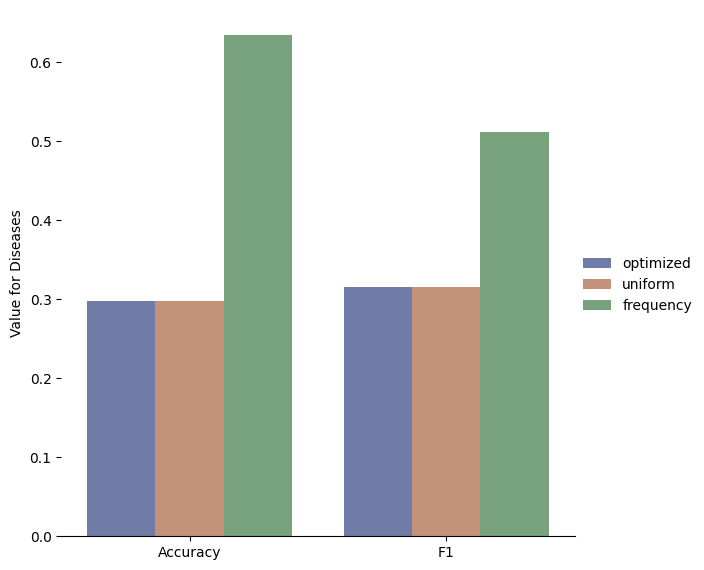

In [259]:
g = sb.catplot(
    data=df[df["Levels"] == "Level 1"], kind="bar",
    x="Metric", y="Values", hue="weights",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Value for Diseases")
g.legend.set_title("")

/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


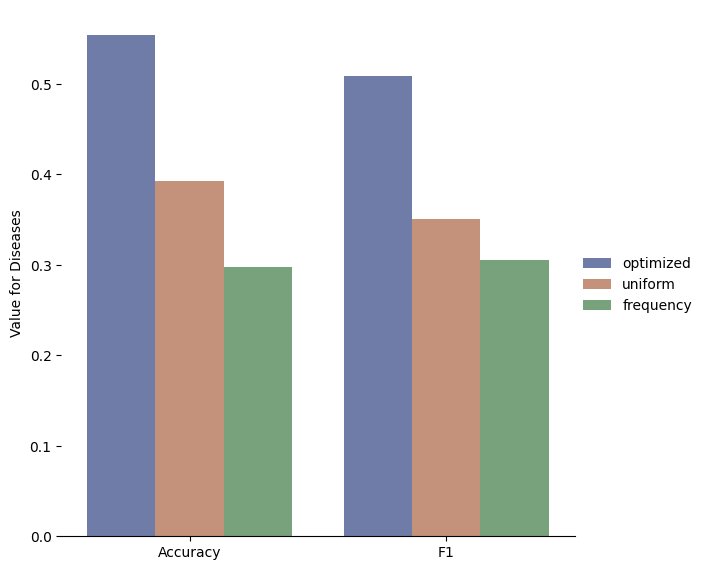

In [258]:
g = sb.catplot(
    data=df[df["Levels"] == "Level 2"], kind="bar",
    x="Metric", y="Values", hue="weights",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Value for Diseases")
g.legend.set_title("")

/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


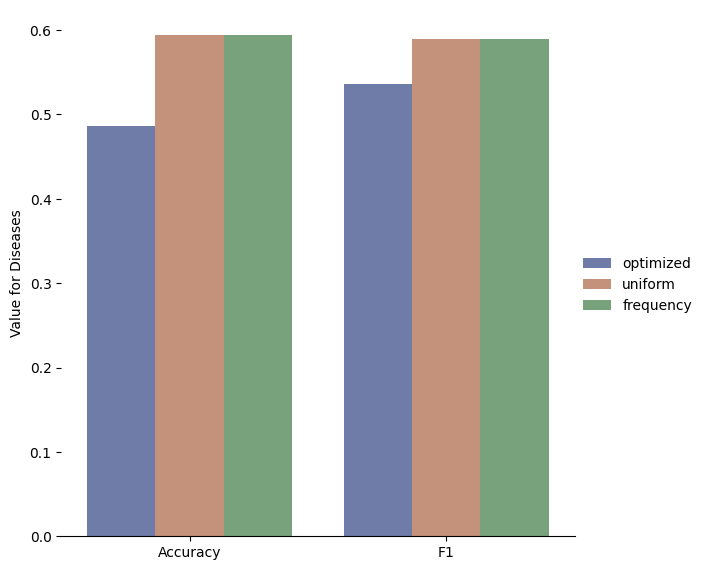

In [257]:
g = sb.catplot(
    data=df[df["Levels"] == "Level 4"], kind="bar",
    x="Metric", y="Values", hue="weights",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Value for Diseases")
g.legend.set_title("")

# Analysis of KNN vs MoGCN

In [296]:
graph = ig.Graph.Adjacency((level1_freq_wa_fused > 0).tolist(), mode = "undirected")
graph.vs["name"] =  level1_graphs["G20"].obs_names
graph.vs["d"] = level1_graphs["G20"].obs.Disease
graph.vs["dg"] = level1_graphs["G20"].obs.DiseaseGroup
graph.es['weight'] = level1_freq_wa_fused[level1_freq_wa_fused.nonzero()]
graph = graph.as_undirected()
    
print(graph.density())

0.9777860051832654


In [297]:
graph = ig.Graph.Adjacency((level2_freq_wa_fused > 0).tolist(), mode = "undirected")
graph.vs["name"] =  level1_graphs["G20"].obs_names
graph.vs["d"] = level1_graphs["G20"].obs.Disease
graph.vs["dg"] = level1_graphs["G20"].obs.DiseaseGroup
graph.es['weight'] = level2_freq_wa_fused[level2_freq_wa_fused.nonzero()]
graph = graph.as_undirected()
    
print(graph.density())

0.8389485375786746


In [298]:
graph = ig.Graph.Adjacency((level4_freq_wa_fused > 0).tolist(), mode = "undirected")
graph.vs["name"] =  level1_graphs["G20"].obs_names
graph.vs["d"] = level1_graphs["G20"].obs.Disease
graph.vs["dg"] = level1_graphs["G20"].obs.DiseaseGroup
graph.es['weight'] = level4_freq_wa_fused[level4_freq_wa_fused.nonzero()]
graph = graph.as_undirected()
    
print(graph.density())

0.4087375046279156


In [294]:
g = level4_snf_fused
g[g<0.005] = 0

# adjacency matrix after filtering
exist = (g != 0) * 1.0
    
factor = np.ones(g.shape[1])
res = np.dot(exist, factor)     #degree of each node
diag_matrix = np.diag(res)  #degree matrix
   
#calculate the laplace matrix
d_inv = np.linalg.inv(diag_matrix)
g_input_to_GCN = d_inv.dot(exist)

In [295]:
graph = ig.Graph.Adjacency((g_input_to_GCN > 0).tolist(), mode = "undirected")
graph.vs["name"] =  level1_graphs["G20"].obs_names
graph.vs["d"] = level1_graphs["G20"].obs.Disease
graph.vs["dg"] = level1_graphs["G20"].obs.DiseaseGroup
graph.es['weight'] = g_input_to_GCN[g_input_to_GCN.nonzero()]
graph = graph.as_undirected()
print(graph.density())

0.3524620510921881


# Selecting the best Fusion + PSN Generation + Clustering tripple

In [56]:
#snf + kernel + sc

fused = compute.snf(list(level1_kernel_PSNs.values()), K=7, t = 40) 
first, second = compute.get_n_clusters(fused)
ca = cluster.spectral_clustering(fused, n_clusters=first, n_init = 40)
cl = assign_labels_to_clusters(ca)
_,_, acc, _ = predictions_and_quality(ca, cl)
print(acc)

0.3918918918918919


In [57]:
set(cl)

{'0', '1', '2', '3'}

In [58]:
#snf + kernel + leiden
fused = compute.snf(list(level1_kernel_PSNs.values()), K=7, t = 40) 
ad_obj =ad.AnnData(fused)
ad_obj.obsp["connectivities"] = fused
scp.tl.leiden(ad_obj, resolution=0.2, adjacency=fused, directed=False, use_weights=True)
ca = list(ad_obj.obs.leiden)
cl = assign_labels_to_clusters(ca)
_,_, acc, _ = predictions_and_quality(ca, cl)
print(acc) 

0.3918918918918919


In [59]:
set(cl)

{'0', '1', '2', '3', '4'}

In [60]:
#wa + kernel + leiden

fused = None
for id in level1_kernel_PSNs.keys():
    if fused is None:
        fused = level1_kernel_PSNs[id] * level1_frequency_weights[id]
    else:
        fused = fused + level1_kernel_PSNs[id] * level1_frequency_weights[id]

ad_obj =ad.AnnData(fused)
ad_obj.obsp["connectivities"] = fused
scp.tl.leiden(ad_obj, resolution=0.014, adjacency=fused, directed=False, use_weights=True)
ca = list(ad_obj.obs.leiden)
cl = assign_labels_to_clusters(ca)
_,_, acc, _ = predictions_and_quality(ca, cl)
print(acc) 

0.17567567567567569


In [61]:
set(cl)

{'0', '1', '2', '3', '4', '5'}

In [62]:
#wa + kernel + sc

fused = None
for id in level1_kernel_PSNs.keys():
    if fused is None:
        fused = level1_kernel_PSNs[id] * level1_frequency_weights[id]
    else:
        fused = fused + level1_kernel_PSNs[id] * level1_frequency_weights[id]


first, second = compute.get_n_clusters(fused)
ca = cluster.spectral_clustering(fused, n_clusters=first, n_init = 40)
cl = assign_labels_to_clusters(ca)
_,_, acc, _ = predictions_and_quality(ca, cl)
print(acc) 

0.22972972972972974


In [63]:
set(cl)

{'0', '1', '2', '3'}

In [64]:
#wa + knn + leiden

fused = None
for id in level1_knn_PSNs.keys():
    if fused is None:
        fused = level1_knn_PSNs[id] * level1_frequency_weights[id]
    else:
        fused = fused + level1_knn_PSNs[id] * level1_frequency_weights[id]
ad_obj =ad.AnnData(fused)
ad_obj.obsp["connectivities"] = fused
scp.tl.leiden(ad_obj, resolution=1, adjacency=fused, directed=False, use_weights=True)
ca = list(ad_obj.obs.leiden)
cl = assign_labels_to_clusters(ca)
_,_, acc, _ = predictions_and_quality(ca, cl)
print(acc) 

0.6351351351351351


In [65]:
set(cl)

{'0', '1', '2', '3', '4'}

In [66]:
#wa + knn + sc
fused = None
for id in level1_knn_PSNs.keys():
    if fused is None:
        fused = level1_knn_PSNs[id] * level1_frequency_weights[id]
    else:
        fused = fused + level1_knn_PSNs[id] * level1_frequency_weights[id]
first, second = compute.get_n_clusters(fused)
ca = cluster.spectral_clustering(fused, n_clusters=first, n_init = 40)
cl = assign_labels_to_clusters(ca)
_,_, acc, _ = predictions_and_quality(ca, cl)
print(acc)

0.0945945945945946


In [67]:
set(cl)

{'0', '1'}

In [68]:
# snf + knn + sc
fused = compute.snf(list(level1_knn_PSNs.values()), K=7, t = 40) 
first, second = compute.get_n_clusters(fused)
ca = cluster.spectral_clustering(fused, n_clusters=first, n_init = 40)
cl = assign_labels_to_clusters(ca)
_,_, acc, _ = predictions_and_quality(ca, cl)
print(acc)

0.25675675675675674


In [69]:
set(cl)

{'0', '1', '2', '3'}

In [70]:
# snf + knn + leiden
fused = compute.snf(list(level1_knn_PSNs.values()), K=7, t = 40) 
ad_obj =ad.AnnData(fused)
ad_obj.obsp["connectivities"] = fused
scp.tl.leiden(ad_obj, resolution=0.66, adjacency=fused, directed=False, use_weights=True)
ca = list(ad_obj.obs.leiden)
cl = assign_labels_to_clusters(ca)
_,_, acc, _ = predictions_and_quality(ca, cl)
print(acc) 

0.35135135135135137


In [71]:
set(cl)

{'0', '1', '2', '3', '4', '5', '6'}

# Saving Data

In [73]:
with open(os.path.join(level1, 'fusions.pickle'), 'wb') as f:
    pickle.dump(level1_fusions, f)
with open(os.path.join(level2, 'fusions.pickle'), 'wb') as f:
    pickle.dump(level2_fusions, f)
with open(os.path.join(level3, 'fusions.pickle'), 'wb') as f:
    pickle.dump(level3_fusions, f)
with open(os.path.join(level4, 'fusions.pickle'), 'wb') as f:
    pickle.dump(level4_fusions, f)

with open(os.path.join(level1, 'cluster_info.pickle'), 'wb') as f:
    pickle.dump(level1_clustering_info, f)
with open(os.path.join(level2, 'cluster_info.pickle'), 'wb') as f:
    pickle.dump(level2_clustering_info, f)
with open(os.path.join(level3, 'cluster_info.pickle'), 'wb') as f:
    pickle.dump(level3_clustering_info, f)
with open(os.path.join(level4, 'cluster_info.pickle'), 'wb') as f:
    pickle.dump(level4_clustering_info, f)

with open(os.path.join(level1, 'predictions.pickle'), 'wb') as f:
    pickle.dump(level1_predicted_labels, f)
with open(os.path.join(level2, 'predictions.pickle'), 'wb') as f:
    pickle.dump(level2_predicted_labels, f)
with open(os.path.join(level3, 'predictions.pickle'), 'wb') as f:
    pickle.dump(level3_predicted_labels, f)
with open(os.path.join(level4, 'predictions.pickle'), 'wb') as f:
    pickle.dump(level4_predicted_labels, f)


# PR score and Sillohuette 

In [372]:
print("SNF: ", skl.metrics.silhouette_score(level1_fusions["snf_kernel"], level1_clustering_info["fused_kernels"]), skl.metrics.silhouette_score(level2_fusions["snf_kernel"], level2_clustering_info["fused_kernels"]), skl.metrics.silhouette_score(level4_fusions["snf_kernel"], level4_clustering_info["fused_kernels"]) )

SNF:  -0.019737733036939303 -0.024323880009884214 -0.017485091275236262


In [383]:
print(compute_pr_score(level1_fusions["snf_kernel"])  , compute_pr_score(level2_fusions["snf_kernel"])  , compute_pr_score(level4_fusions["snf_kernel"])  )

0.0814593114961446 0.11739786591123075 0.14487404114220145


In [393]:
print("MoGCN: ", skl.metrics.silhouette_score(g1, l1), skl.metrics.silhouette_score(g2, l2), skl.metrics.silhouette_score(g3, l3))

/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


MoGCN:  0.13444047318220056 0.17189949291017054 0.48800713674389057


In [394]:
print(compute_pr_score(g1)  , compute_pr_score(g2)  , compute_pr_score(g3)  )

0.3078067731106824 0.2816213362933112 0.2855375422813234


In [384]:
print("Corr: ", skl.metrics.silhouette_score(level1_fusions["snf_correlation"], level1_clustering_info["fused_correlations"]), skl.metrics.silhouette_score(level2_fusions["snf_correlation"], level2_clustering_info["fused_correlations"]), skl.metrics.silhouette_score(level4_fusions["snf_correlation"], level4_clustering_info["fused_correlations"]) )

Corr:  -0.020293358590782785 -0.0251366325907332 -0.018091576166528255


In [385]:
print(compute_pr_score(level1_fusions["snf_correlation"])  , compute_pr_score(level2_fusions["snf_correlation"])  , compute_pr_score(level4_fusions["snf_correlation"])  )

0.06125821242151652 0.08663388424853316 0.12289503252268566


In [379]:
print("Corr: ", skl.metrics.silhouette_score(level1_fusions["wa_knn_frequency"], level1_clustering_info["fused_knn_frequency"]), skl.metrics.silhouette_score(level2_fusions["wa_knn_frequency"], level2_clustering_info["fused_knn_frequency"]), skl.metrics.silhouette_score(level4_fusions["wa_knn_frequency"], level4_clustering_info["fused_knn_frequency"]) )

Corr:  0.0894974289646443 0.05848833638380787 0.09088918553424694


In [386]:
print(compute_pr_score(level1_fusions["wa_knn_frequency"])  , compute_pr_score(level2_fusions["wa_knn_frequency"])  , compute_pr_score(level4_fusions["wa_knn_frequency"])  )

0.2629739438561563 0.2738252260625257 0.315721501120421


# Visualization of Predictions

## L1

Text(0.5, 1.0, 'Disease Group')

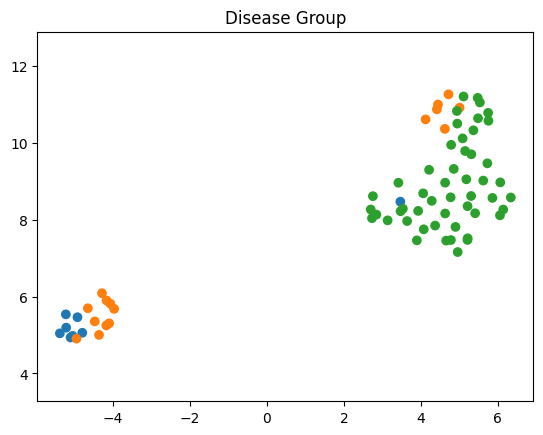

In [702]:
dg_dataframe = pd.DataFrame(list(level1_graphs["G0"].obs.DiseaseGroup.to_dict().values()), index = list(level1_graphs["G0"].obs.DiseaseGroup.to_dict().keys()),  columns = ["DiseaseGroup"])
df = pd.DataFrame(l1_unimodal_kernel_binary_preds_dg)
reducer = umap.UMAP()
embedding1 = reducer.fit_transform(df)

#fig, ax = plt.subplots(1,2, figsize=(20,20))
plt.scatter(
    embedding1[:, 0],
    embedding1[:, 1],
    c=[sb.color_palette()[x] for x in dg_dataframe.DiseaseGroup.map({"Healthy":0, "Sepsis":1, "COVID":2})])
plt.gca().set_aspect('equal', 'datalim')
plt.title("Disease Group")

Text(0.5, 1.0, 'Disease Group')

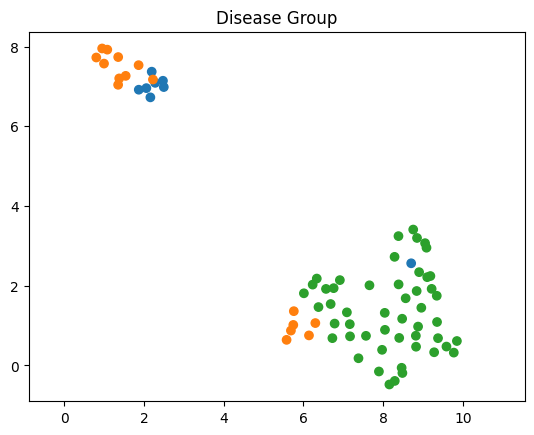

In [703]:
dg_dataframe = pd.DataFrame(list(level1_graphs["G0"].obs.DiseaseGroup.to_dict().values()), index = list(level1_graphs["G0"].obs.DiseaseGroup.to_dict().keys()),  columns = ["DiseaseGroup"])
df = pd.DataFrame(l1_unimodal_corr_binary_preds_dg)
reducer = umap.UMAP()
embedding1 = reducer.fit_transform(df)

#fig, ax = plt.subplots(1,2, figsize=(20,20))
plt.scatter(
    embedding1[:, 0],
    embedding1[:, 1],
    c=[sb.color_palette()[x] for x in dg_dataframe.DiseaseGroup.map({"Healthy":0, "Sepsis":1, "COVID":2, "None":3})])
plt.gca().set_aspect('equal', 'datalim')
plt.title("Disease Group")

Text(0.5, 1.0, 'Disease Group')

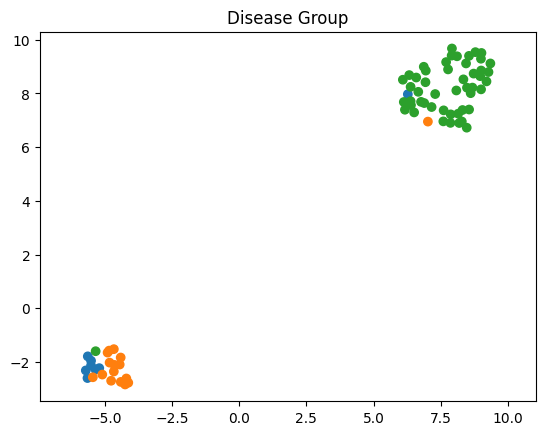

In [664]:
dg_dataframe = pd.DataFrame(list(level1_graphs["G0"].obs.DiseaseGroup.to_dict().values()), index = list(level1_graphs["G0"].obs.DiseaseGroup.to_dict().keys()),  columns = ["DiseaseGroup"])
df = pd.DataFrame(l1_unimodal_knn_binary_preds_dg)
reducer = umap.UMAP()
embedding1 = reducer.fit_transform(df)

#fig, ax = plt.subplots(1,2, figsize=(20,20))
plt.scatter(
    embedding1[:, 0],
    embedding1[:, 1],
    c=[sb.color_palette()[x] for x in dg_dataframe.DiseaseGroup.map({"Healthy":0, "Sepsis":1, "COVID":2, "None":3})])
plt.gca().set_aspect('equal', 'datalim')
plt.title("Disease Group")

## L2

<Axes: >

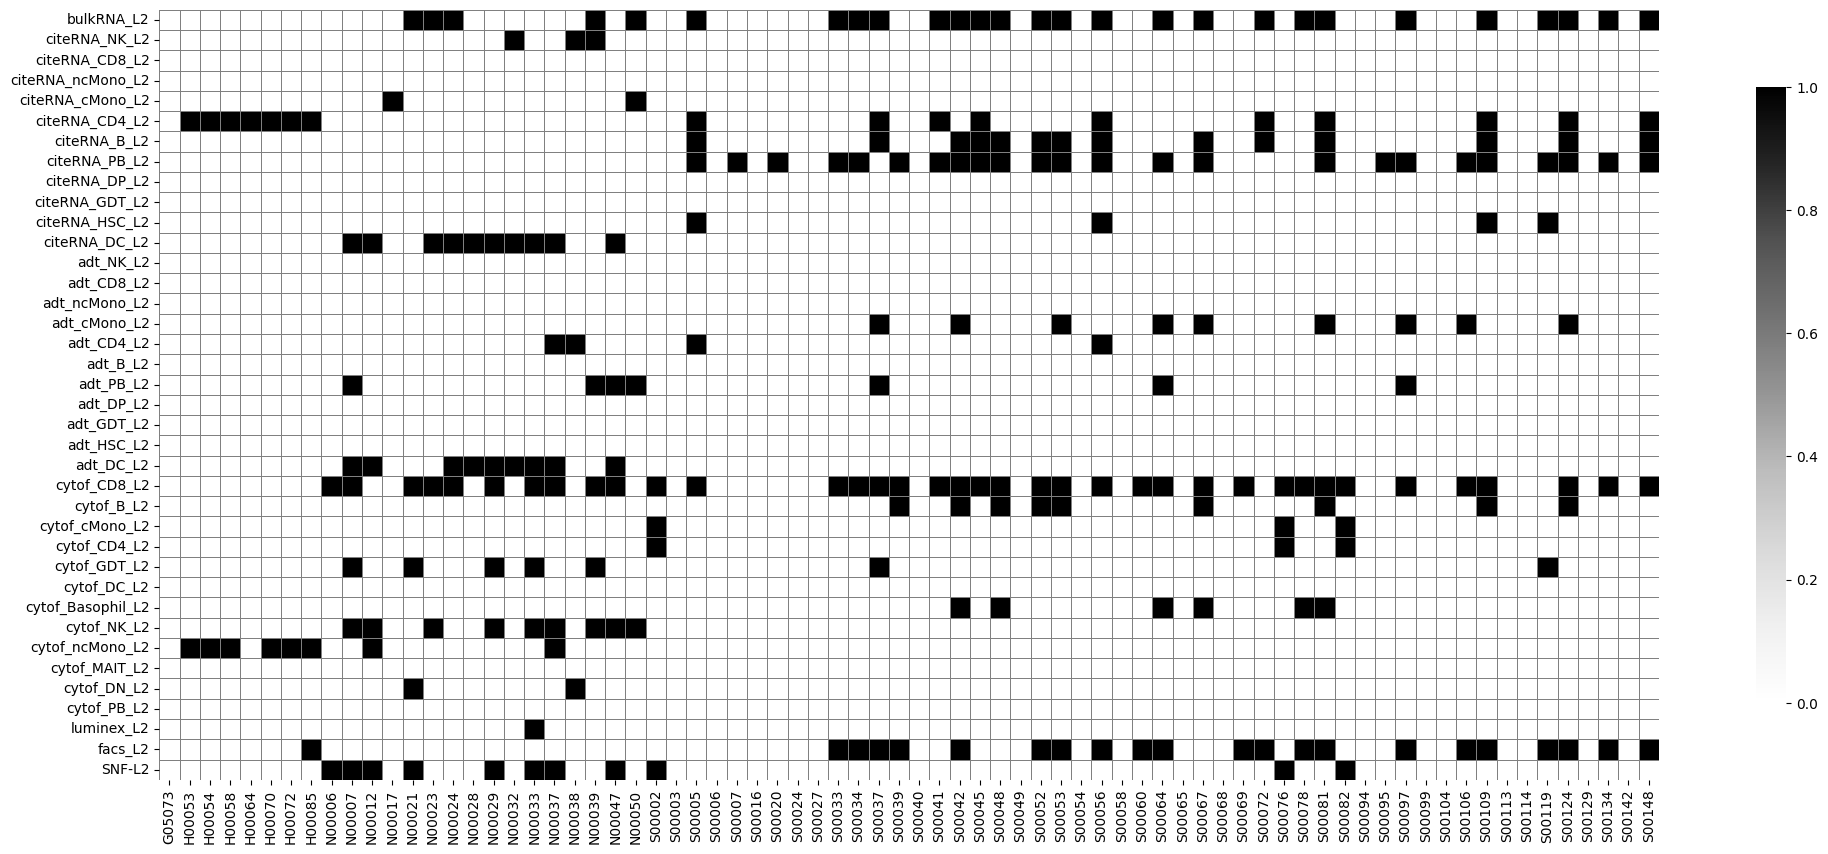

In [573]:
fig, ax = plt.subplots(figsize=(25,10))
sb.heatmap(pd.DataFrame(l2_unimodal_kernel_binary_preds_d | {"SNF-L2" : binary_predictions_d["SNF-L2"]}, index = patients_74).T, cmap="Greys", ax = ax, square=True, robust = False, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.8}, cbar = True)

<Axes: >

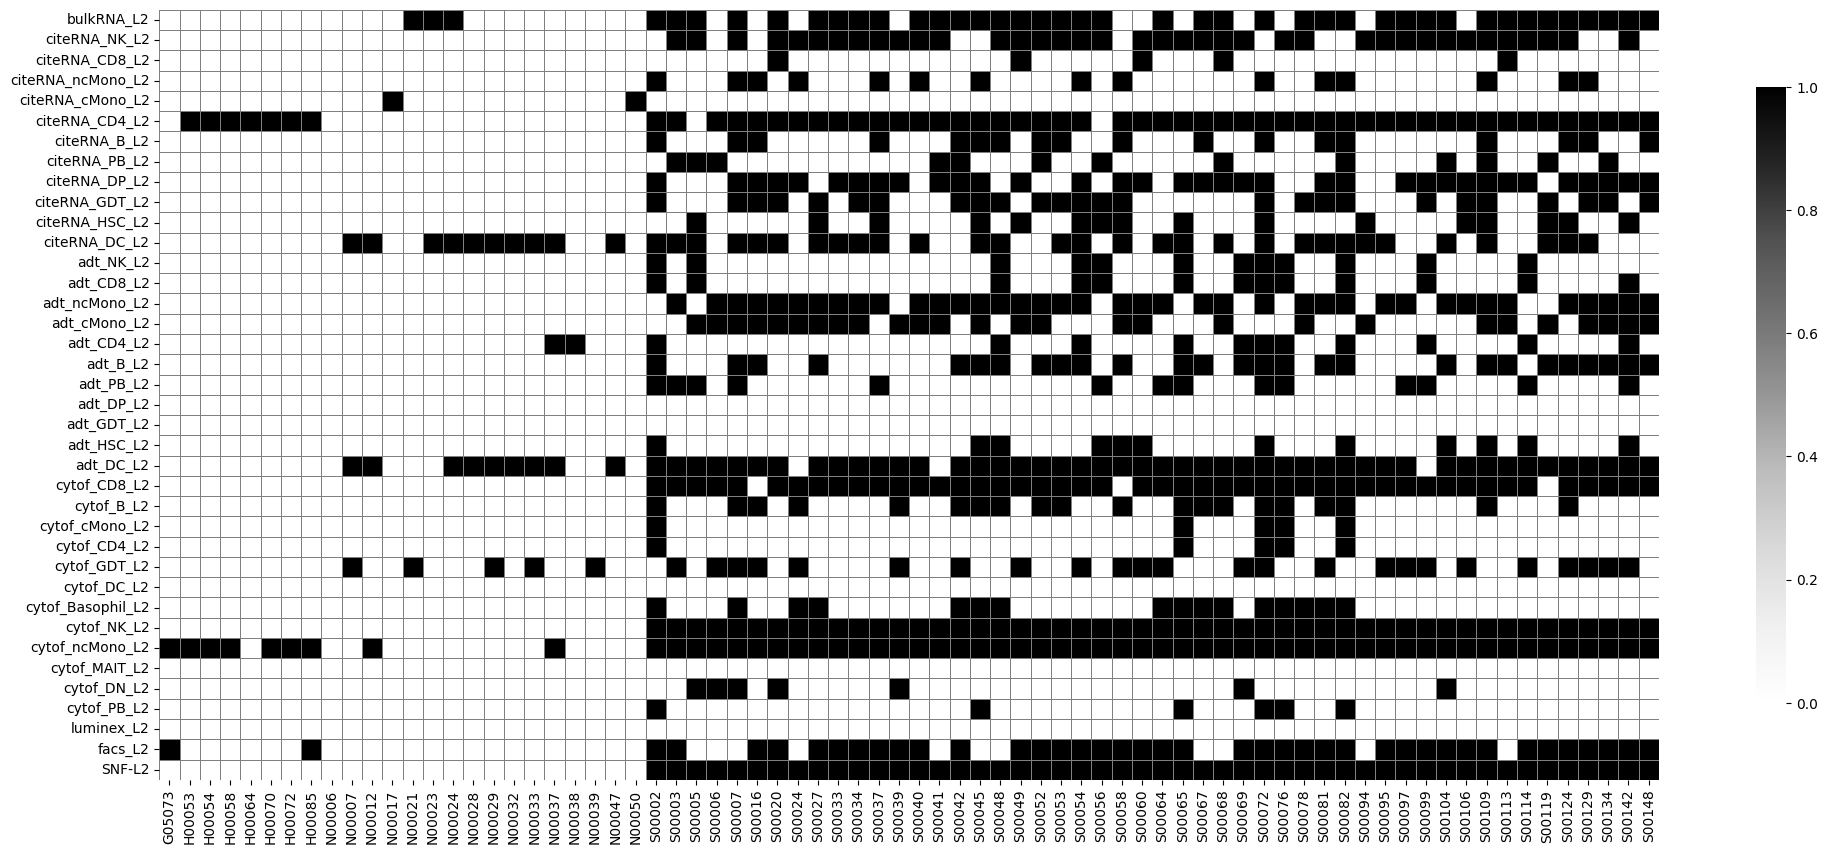

In [574]:
fig, ax = plt.subplots(figsize=(25,10))
sb.heatmap(pd.DataFrame(l2_unimodal_kernel_binary_preds_dg | {"SNF-L2" : binary_predictions_dg["SNF-L2"]}, index = patients_74).T, cmap="Greys", ax = ax, square=True, robust = False, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.8}, cbar = True)

Text(0.5, 1.0, 'Disease Group')

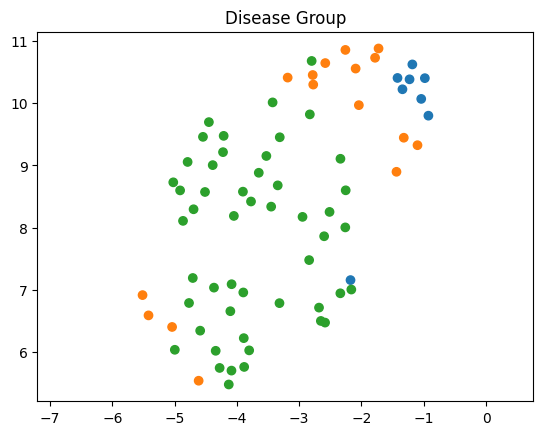

In [665]:
dg_dataframe = pd.DataFrame(list(level1_graphs["G0"].obs.DiseaseGroup.to_dict().values()), index = list(level1_graphs["G0"].obs.DiseaseGroup.to_dict().keys()),  columns = ["DiseaseGroup"])
df = pd.DataFrame(l2_unimodal_kernel_binary_preds_dg)
reducer = umap.UMAP()
embedding1 = reducer.fit_transform(df)

#fig, ax = plt.subplots(1,2, figsize=(20,20))
plt.scatter(
    embedding1[:, 0],
    embedding1[:, 1],
    c=[sb.color_palette()[x] for x in dg_dataframe.DiseaseGroup.map({"Healthy":0, "Sepsis":1, "COVID":2})])
plt.gca().set_aspect('equal', 'datalim')
plt.title("Disease Group")

<Axes: >

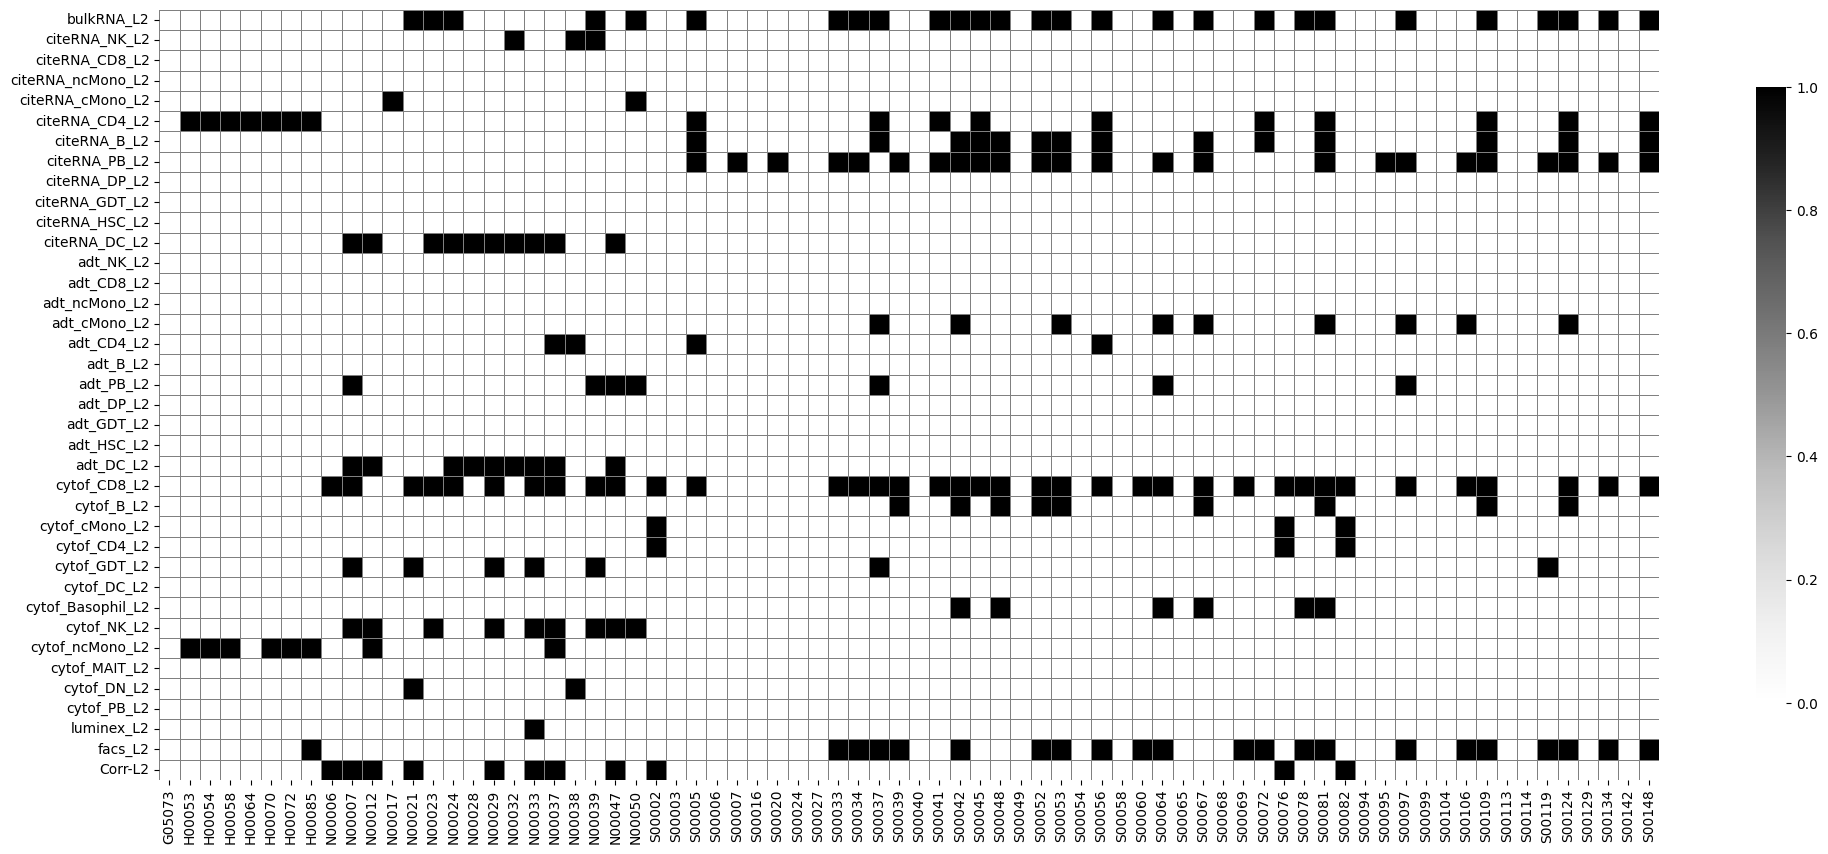

In [582]:
fig, ax = plt.subplots(figsize=(25,10))
sb.heatmap(pd.DataFrame(l2_unimodal_corr_binary_preds_d | {"Corr-L2" : binary_predictions_d["Corr-L2"]}, index = patients_74).T, cmap="Greys", ax = ax, square=True, robust = False, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.8}, cbar = True)

<Axes: >

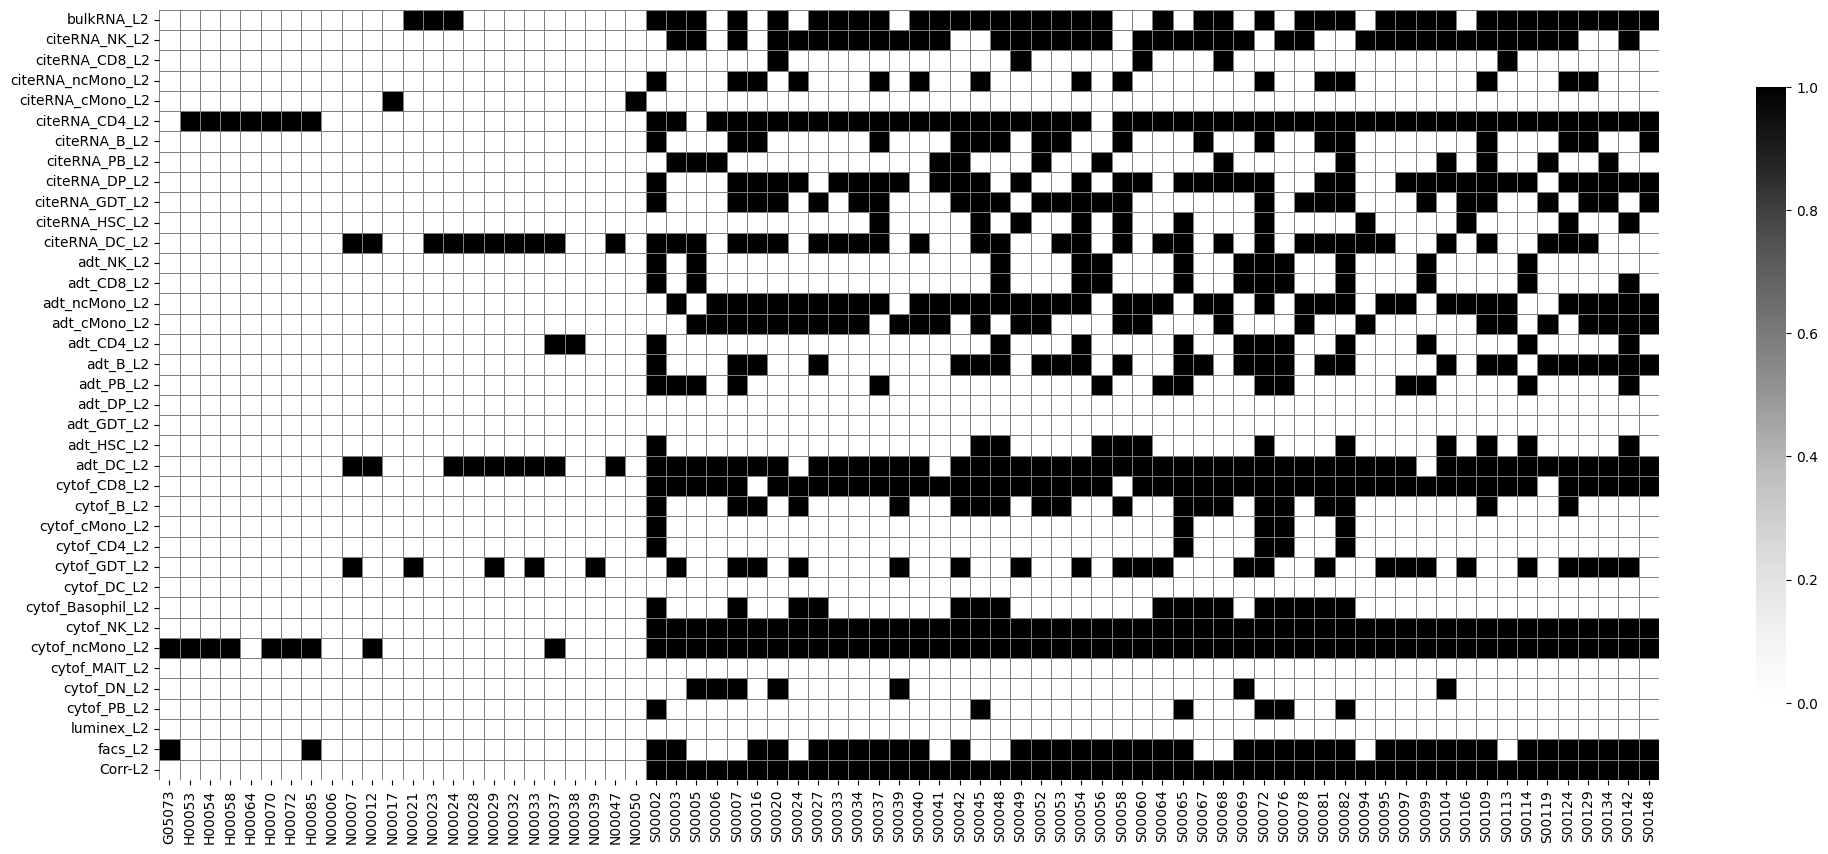

In [583]:
fig, ax = plt.subplots(figsize=(25,10))
sb.heatmap(pd.DataFrame(l2_unimodal_corr_binary_preds_dg | {"Corr-L2" : binary_predictions_dg["Corr-L2"]}, index = patients_74).T, cmap="Greys", ax = ax, square=True, robust = False, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.8}, cbar = True)

Text(0.5, 1.0, 'Disease Group')

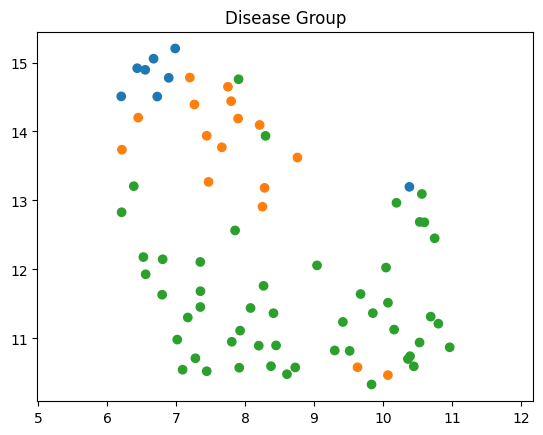

In [666]:
dg_dataframe = pd.DataFrame(list(level1_graphs["G0"].obs.DiseaseGroup.to_dict().values()), index = list(level1_graphs["G0"].obs.DiseaseGroup.to_dict().keys()),  columns = ["DiseaseGroup"])
df = pd.DataFrame(l2_unimodal_corr_binary_preds_dg)
reducer = umap.UMAP()
embedding1 = reducer.fit_transform(df)

#fig, ax = plt.subplots(1,2, figsize=(20,20))
plt.scatter(
    embedding1[:, 0],
    embedding1[:, 1],
    c=[sb.color_palette()[x] for x in dg_dataframe.DiseaseGroup.map({"Healthy":0, "Sepsis":1, "COVID":2})])
plt.gca().set_aspect('equal', 'datalim')
plt.title("Disease Group")

<Axes: >

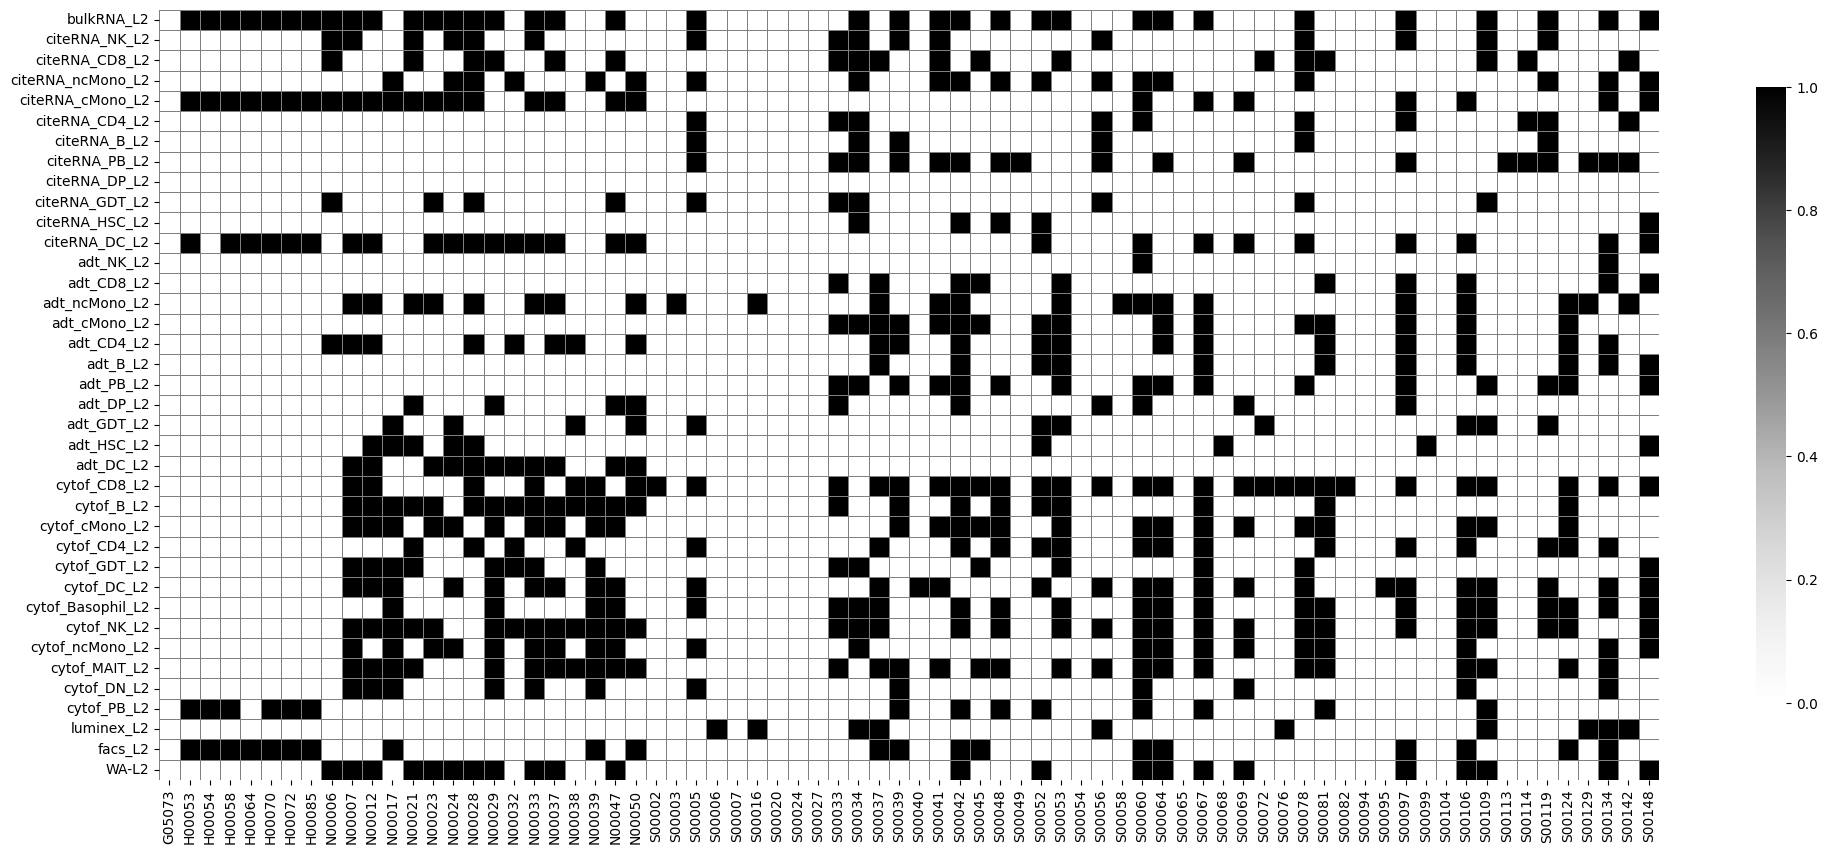

In [575]:
fig, ax = plt.subplots(figsize=(25,10))
sb.heatmap(pd.DataFrame(l2_unimodal_knn_binary_preds_d | {"WA-L2" : binary_predictions_d["WA-L2"]}, index = patients_74).T, cmap="Greys", ax = ax, square=True, robust = False, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.8}, cbar = True)

<Axes: >

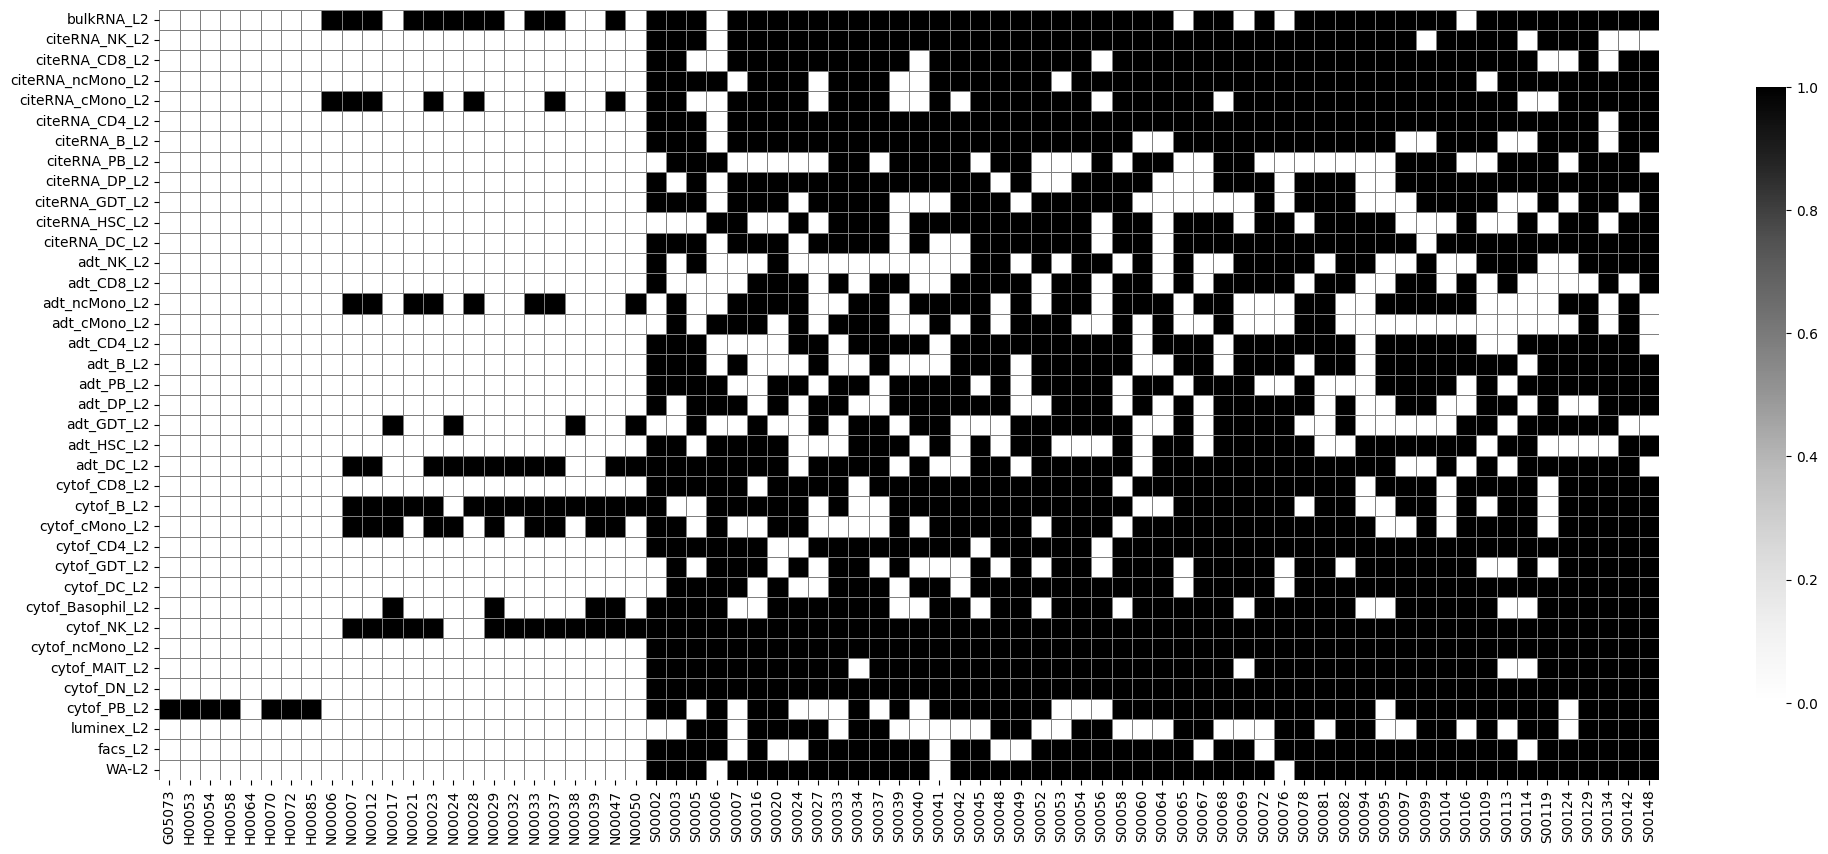

In [576]:
fig, ax = plt.subplots(figsize=(25,10))
sb.heatmap(pd.DataFrame(l2_unimodal_knn_binary_preds_dg | {"WA-L2" : binary_predictions_dg["WA-L2"]}, index = patients_74).T, cmap="Greys", ax = ax, square=True, robust = False, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.8}, cbar = True)

Text(0.5, 1.0, 'Disease Group')

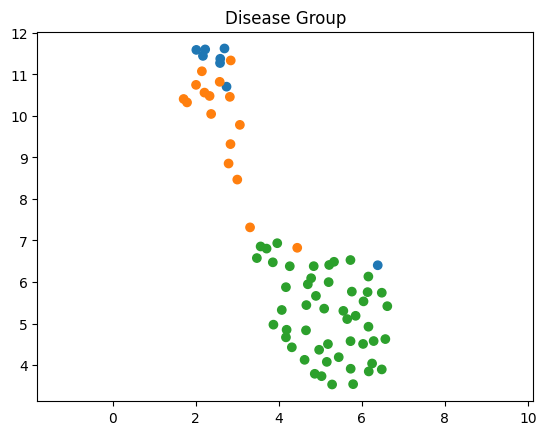

In [667]:
dg_dataframe = pd.DataFrame(list(level1_graphs["G0"].obs.DiseaseGroup.to_dict().values()), index = list(level1_graphs["G0"].obs.DiseaseGroup.to_dict().keys()),  columns = ["DiseaseGroup"])
df = pd.DataFrame(l2_unimodal_knn_binary_preds_dg)
reducer = umap.UMAP()
embedding1 = reducer.fit_transform(df)

#fig, ax = plt.subplots(1,2, figsize=(20,20))
plt.scatter(
    embedding1[:, 0],
    embedding1[:, 1],
    c=[sb.color_palette()[x] for x in dg_dataframe.DiseaseGroup.map({"Healthy":0, "Sepsis":1, "COVID":2})])
plt.gca().set_aspect('equal', 'datalim')
plt.title("Disease Group")

## L3

<Axes: >

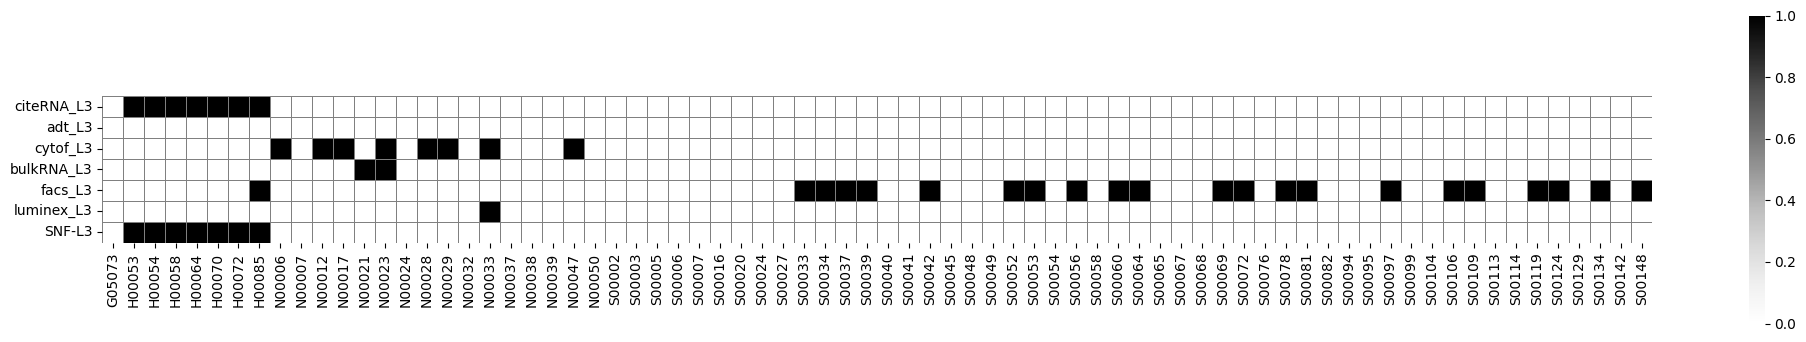

In [578]:
fig, ax = plt.subplots(figsize=(25,5))
df = pd.DataFrame(l3_unimodal_kernel_binary_preds_d | {"SNF-L3" : binary_predictions_d["SNF-L3"]}, index = patients_74).T.rename({i: i.split("4")[0] + "3" for i in l3_unimodal_kernel_binary_preds_d.keys() })
sb.heatmap(df, cmap="Greys", ax = ax, square=True, robust = False, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.8}, cbar = True)

<Axes: >

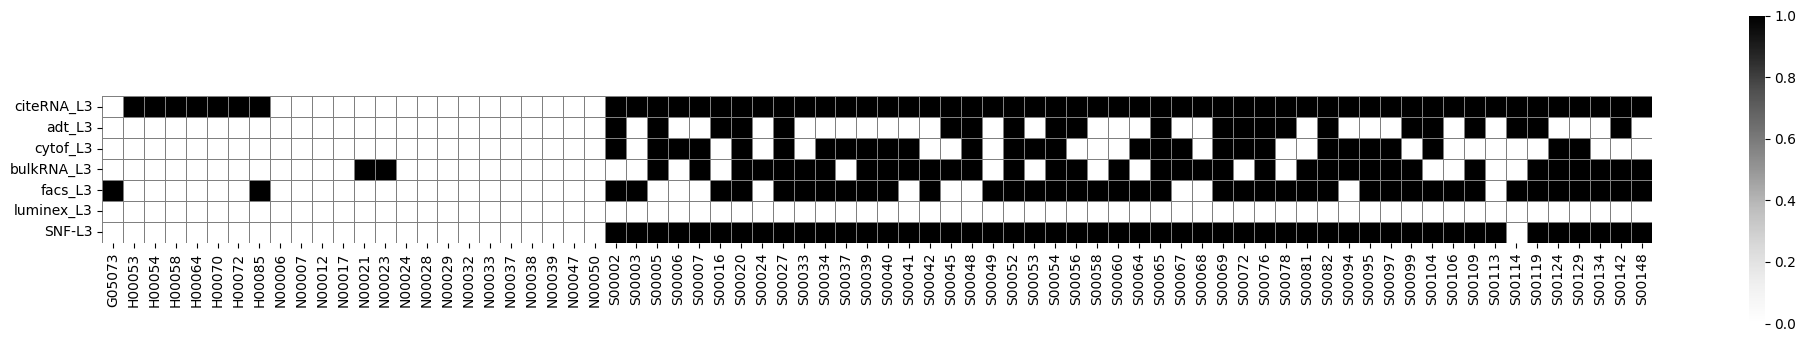

In [579]:
fig, ax = plt.subplots(figsize=(25,5))
df = pd.DataFrame(l3_unimodal_kernel_binary_preds_dg | {"SNF-L3" : binary_predictions_dg["SNF-L3"]}, index = patients_74).T.rename({i: i.split("4")[0] + "3" for i in l3_unimodal_kernel_binary_preds_d.keys() })
sb.heatmap(df, cmap="Greys", ax = ax, square=True, robust = False, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.8}, cbar = True)

Text(0.5, 1.0, 'Disease Group')

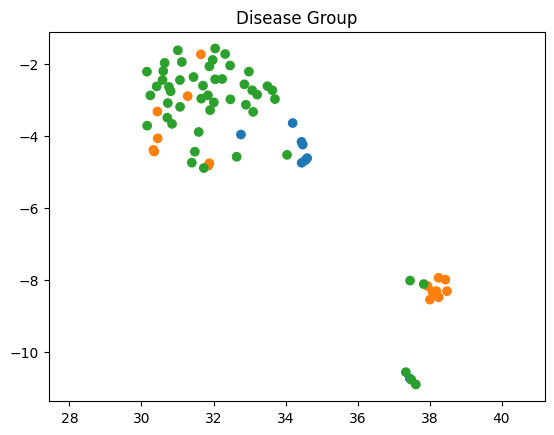

In [675]:
dg_dataframe = pd.DataFrame(list(level1_graphs["G0"].obs.DiseaseGroup.to_dict().values()), index = list(level1_graphs["G0"].obs.DiseaseGroup.to_dict().keys()),  columns = ["DiseaseGroup"])
df = pd.DataFrame(l3_unimodal_kernel_binary_preds_dg)
reducer = umap.UMAP()
embedding1 = reducer.fit_transform(df)

#fig, ax = plt.subplots(1,2, figsize=(20,20))
plt.scatter(
    embedding1[:, 0],
    embedding1[:, 1],
    c=[sb.color_palette()[x] for x in dg_dataframe.DiseaseGroup.map({"Healthy":0, "Sepsis":1, "COVID":2})])
plt.gca().set_aspect('equal', 'datalim')
plt.title("Disease Group")

<Axes: >

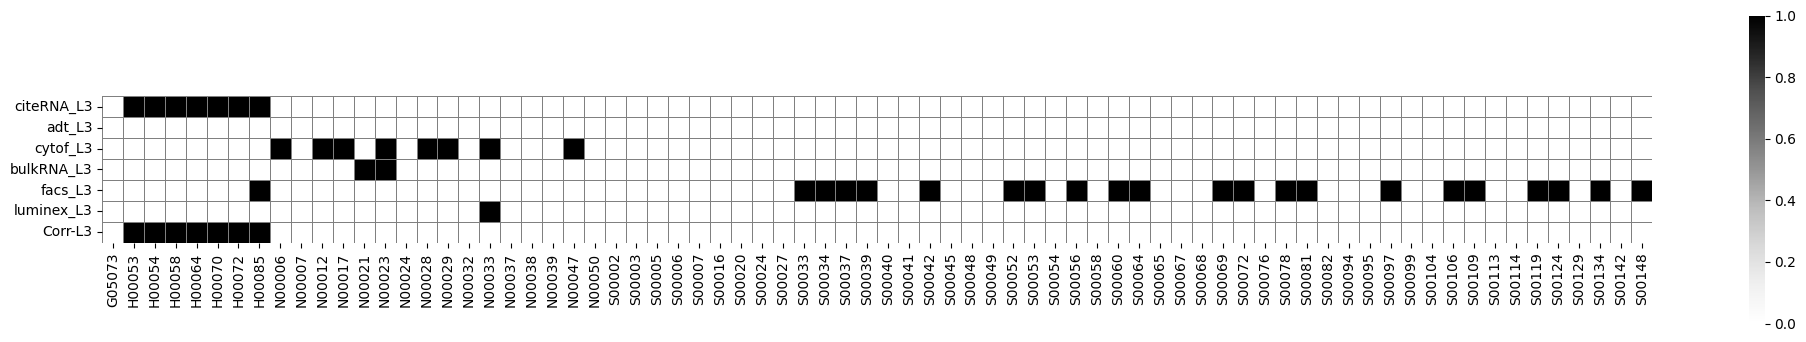

In [585]:
fig, ax = plt.subplots(figsize=(25,5))
df = pd.DataFrame(l3_unimodal_corr_binary_preds_d | {"Corr-L3" : binary_predictions_d["Corr-L3"]}, index = patients_74).T.rename({i: i.split("4")[0] + "3" for i in l3_unimodal_corr_binary_preds_d.keys() })
sb.heatmap(df, cmap="Greys", ax = ax, square=True, robust = False, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.8}, cbar = True)

<Axes: >

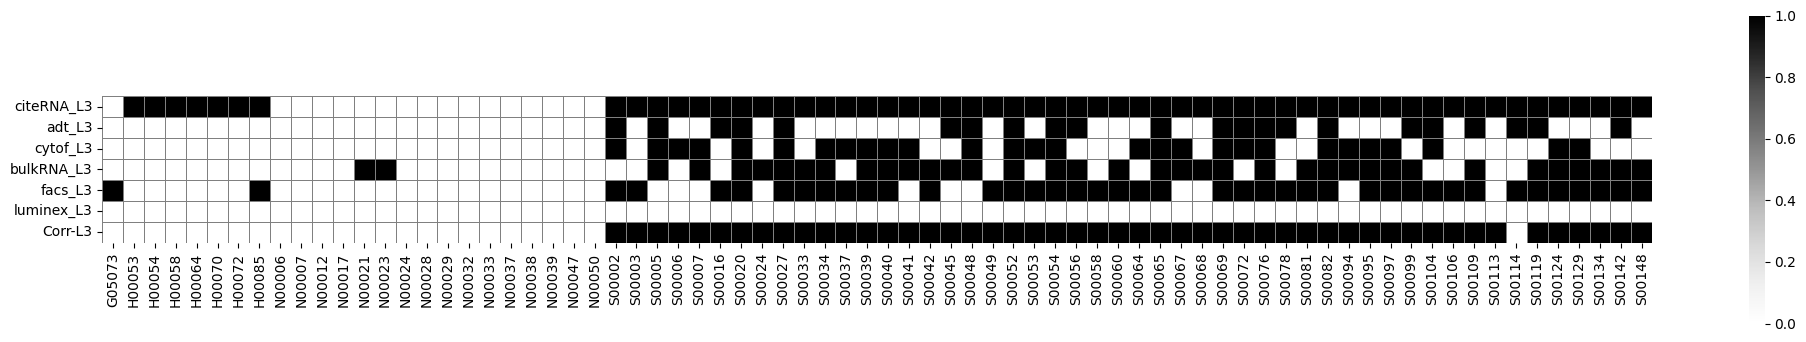

In [586]:
fig, ax = plt.subplots(figsize=(25,5))
df = pd.DataFrame(l3_unimodal_corr_binary_preds_dg | {"Corr-L3" : binary_predictions_dg["Corr-L3"]}, index = patients_74).T.rename({i: i.split("4")[0] + "3" for i in l3_unimodal_corr_binary_preds_d.keys() })
sb.heatmap(df, cmap="Greys", ax = ax, square=True, robust = False, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.8}, cbar = True)

Text(0.5, 1.0, 'Disease Group')

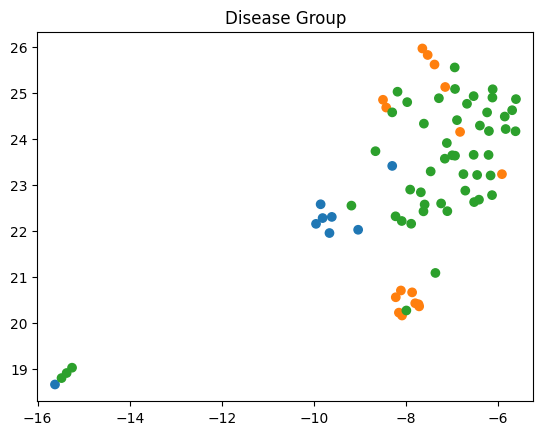

In [705]:
dg_dataframe = pd.DataFrame(list(level1_graphs["G0"].obs.DiseaseGroup.to_dict().values()), index = list(level1_graphs["G0"].obs.DiseaseGroup.to_dict().keys()),  columns = ["DiseaseGroup"])
df = pd.DataFrame(l3_unimodal_corr_binary_preds_dg)
reducer = umap.UMAP()
embedding1 = reducer.fit_transform(df)

#fig, ax = plt.subplots(1,2, figsize=(20,20))
plt.scatter(
    embedding1[:, 0],
    embedding1[:, 1],
    c=[sb.color_palette()[x] for x in dg_dataframe.DiseaseGroup.map({"Healthy":0, "Sepsis":1, "COVID":2})])
plt.gca().set_aspect('equal', 'datalim')
plt.title("Disease Group")

<Axes: >

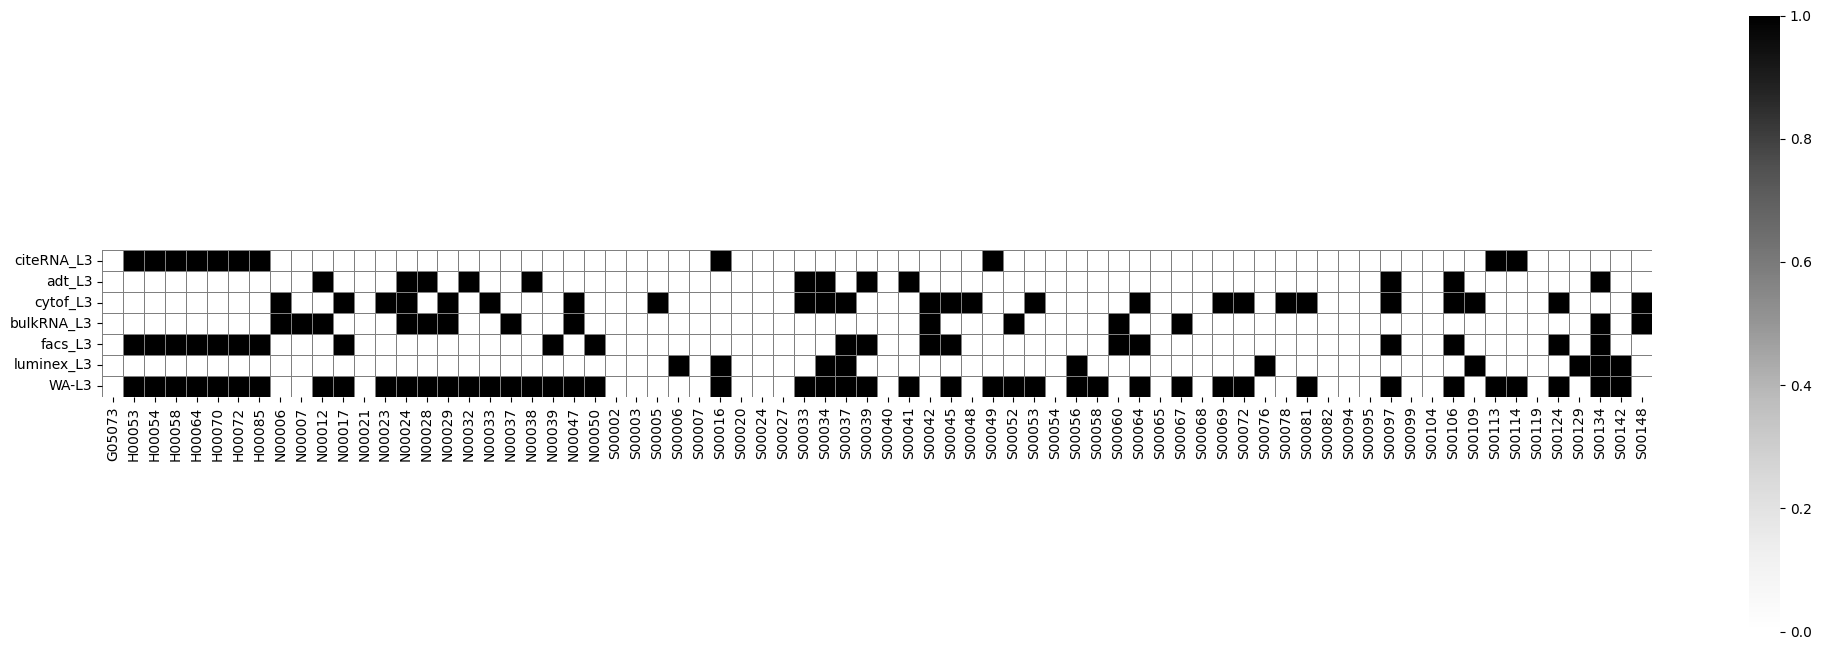

In [587]:
fig, ax = plt.subplots(figsize=(25,10))
df = pd.DataFrame(l3_unimodal_knn_binary_preds_d | {"WA-L3" : binary_predictions_d["WA-L3"]}, index = patients_74).T.rename({i: i.split("4")[0] + "3" for i in l3_unimodal_knn_binary_preds_d.keys() })
sb.heatmap(df, cmap="Greys", ax = ax, square=True, robust = False, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.8}, cbar = True)

<Axes: >

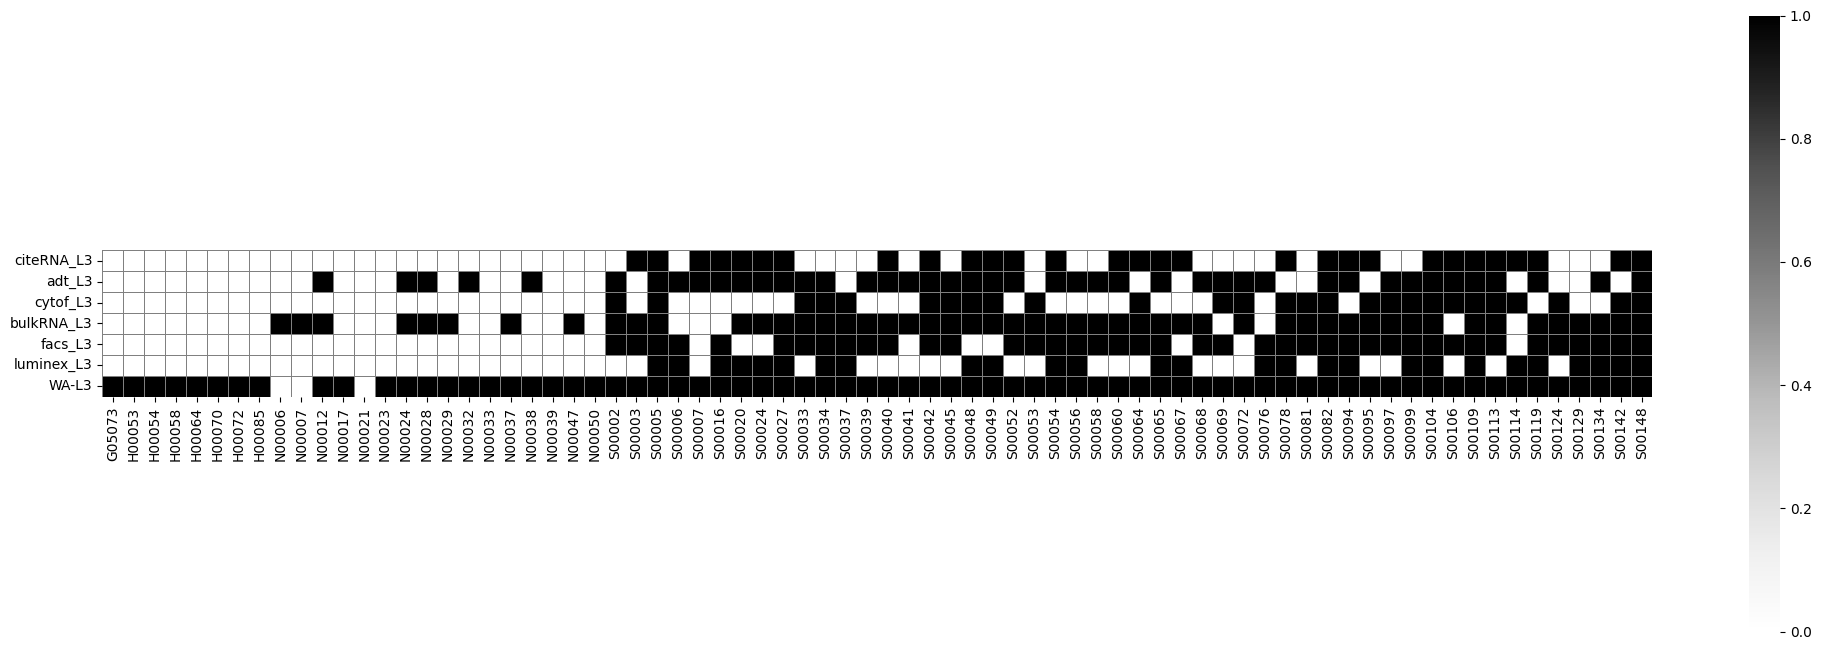

In [588]:
fig, ax = plt.subplots(figsize=(25,10))
df = pd.DataFrame(l3_unimodal_knn_binary_preds_dg | {"WA-L3" : binary_predictions_dg["WA-L3"]}, index = patients_74).T.rename({i: i.split("4")[0] + "3" for i in l3_unimodal_knn_binary_preds_d.keys() })
sb.heatmap(df, cmap="Greys", ax = ax, square=True, robust = False, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.8}, cbar = True)

Text(0.5, 1.0, 'Disease Group')

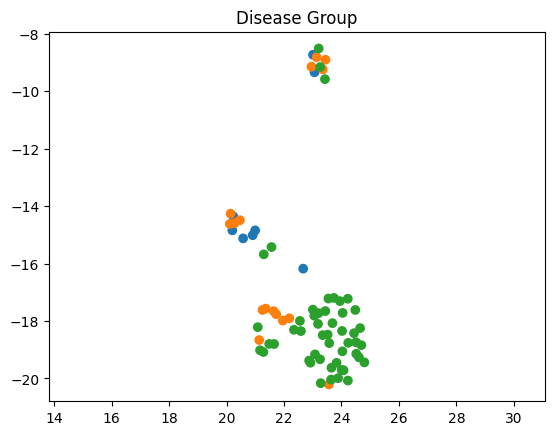

In [677]:
dg_dataframe = pd.DataFrame(list(level1_graphs["G0"].obs.DiseaseGroup.to_dict().values()), index = list(level1_graphs["G0"].obs.DiseaseGroup.to_dict().keys()),  columns = ["DiseaseGroup"])
df = pd.DataFrame(l3_unimodal_knn_binary_preds_dg)
reducer = umap.UMAP()
embedding1 = reducer.fit_transform(df)

#fig, ax = plt.subplots(1,2, figsize=(20,20))
plt.scatter(
    embedding1[:, 0],
    embedding1[:, 1],
    c=[sb.color_palette()[x] for x in dg_dataframe.DiseaseGroup.map({"Healthy":0, "Sepsis":1, "COVID":2})])
plt.gca().set_aspect('equal', 'datalim')
plt.title("Disease Group")

<Axes: >

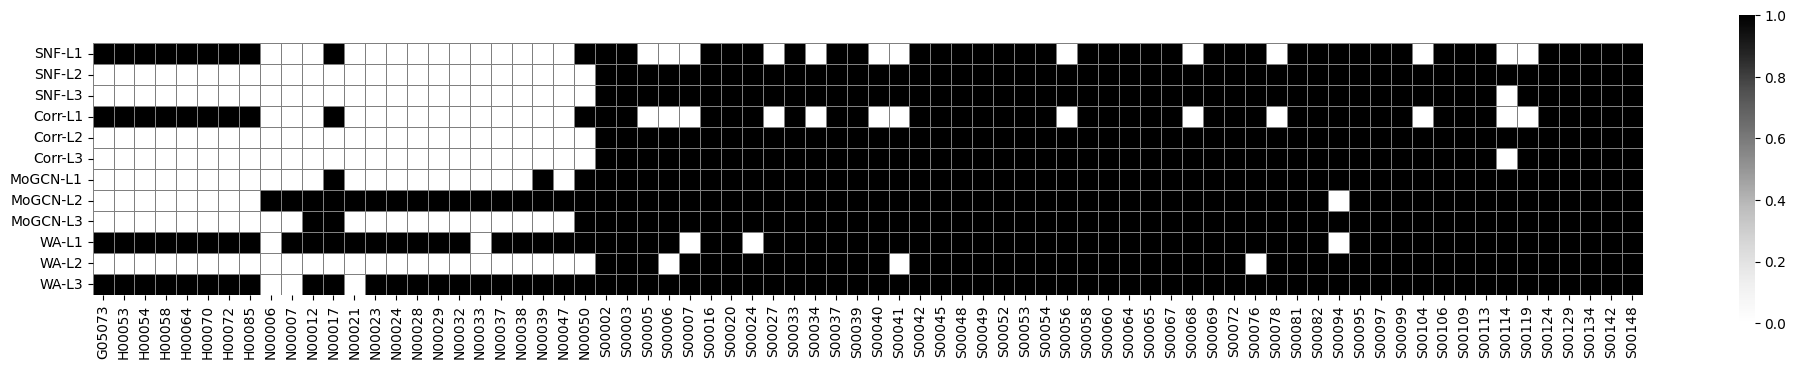

In [653]:
fig, ax = plt.subplots(figsize=(25,5))
sb.heatmap(pd.DataFrame(binary_predictions_dg, index = patients_74).T, cmap="Greys", ax = ax, square=True, robust = False, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.8}, cbar = True)

In [692]:
round(pd.DataFrame(binary_predictions_dg | {"disease": list(level1_graphs["G0"].obs.DiseaseGroup)}, index = patients_74).groupby("disease").mean() * 100, 2)

,SNF-L1,SNF-L2,SNF-L3,Corr-L1,Corr-L2,Corr-L3,MoGCN-L1,MoGCN-L2,MoGCN-L3,WA-L1,WA-L2,WA-L3
disease,,,,,,,,,,,,
COVID,74.0,100.0,98.0,74.0,100.0,98.0,100.00,98.0,100.00,94.0,94.0,100.00
Healthy,100.0,0.0,0.0,100.0,0.0,0.0,0.00,0.0,0.00,100.0,0.0,100.00
Sepsis,12.5,0.0,0.0,12.5,0.0,0.0,18.75,100.0,18.75,87.5,0.0,81.25


<Axes: >

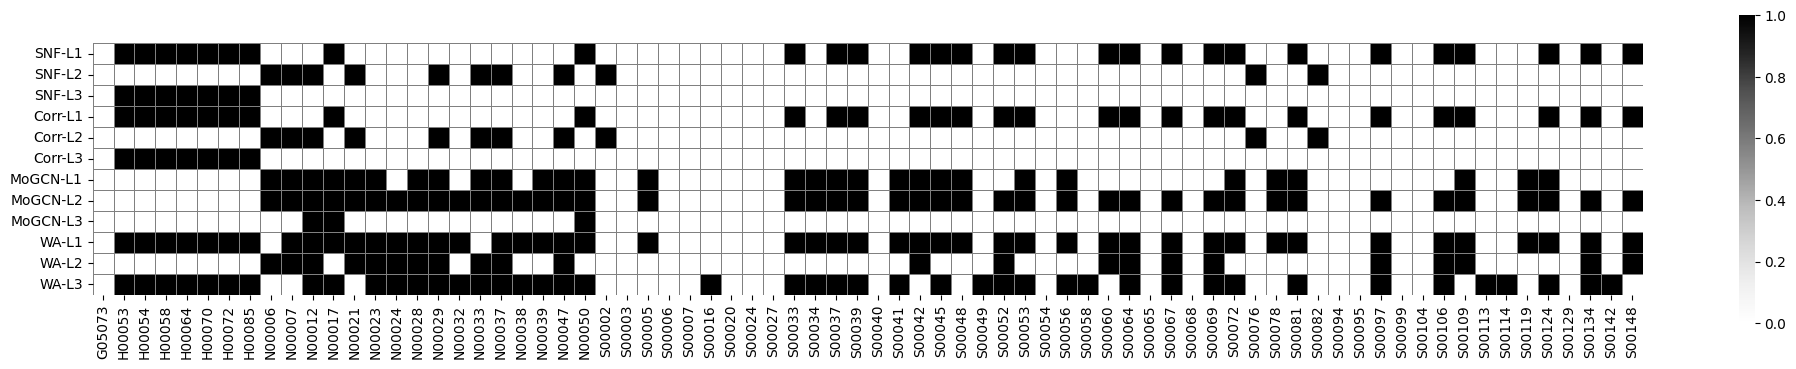

In [652]:
fig, ax = plt.subplots(figsize=(25,5))
sb.heatmap(pd.DataFrame(binary_predictions_d, index = patients_74).T, cmap="Greys", ax = ax, square=True, robust = False, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.8}, cbar = True)